In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from astropy.io import fits

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


In [3]:
WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


# Define paths to spectral atlases 

In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


Define also the spectral types 

In [29]:
spectral_types = ['O','B','A','F','G','K','M']

# Select a spectral atlas 
Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [17]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [18]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

File Type      Teff     Name
0      pickles_uk_1.fits  O5V  39810.70  unknown
1      pickles_uk_2.fits  O9V  35481.40  unknown
2      pickles_uk_3.fits  B0V  28183.80  unknown
3      pickles_uk_4.fits  B1V  22387.20  unknown
4      pickles_uk_5.fits  B3V  19054.60  unknown
..                   ...  ...       ...      ...
126  pickles_uk_127.fits  G8I   4591.98  unknown
127  pickles_uk_128.fits  K2I   4255.98  unknown
128  pickles_uk_129.fits  K3I       NaN  unknown
129  pickles_uk_130.fits  K4I   3990.25  unknown
130  pickles_uk_131.fits  M2I   3451.44  unknown

[131 rows x 4 columns]

# Load with pysynphot the spectra from the selected atlas 

In [20]:
sed_list = np.array(atlas_seds['File'])

In [21]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

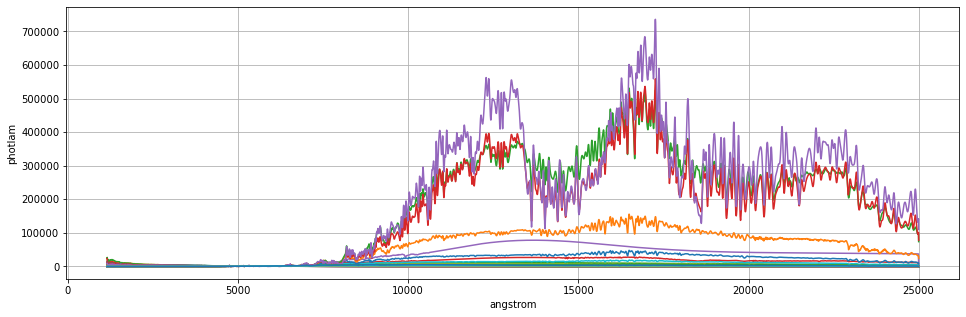

In [25]:
fig=plt.figure(figsize=(16,5))
for sed_ in sed_dict.keys():
    spec = sed_dict[sed_]
    spec.convert('photlam')
    plt.plot(spec.wave,spec.flux)
    plt.xlabel(spec.waveunits)
    plt.ylabel(spec.fluxunits)
    #plt.xlim((0,10000))
    plt.grid()


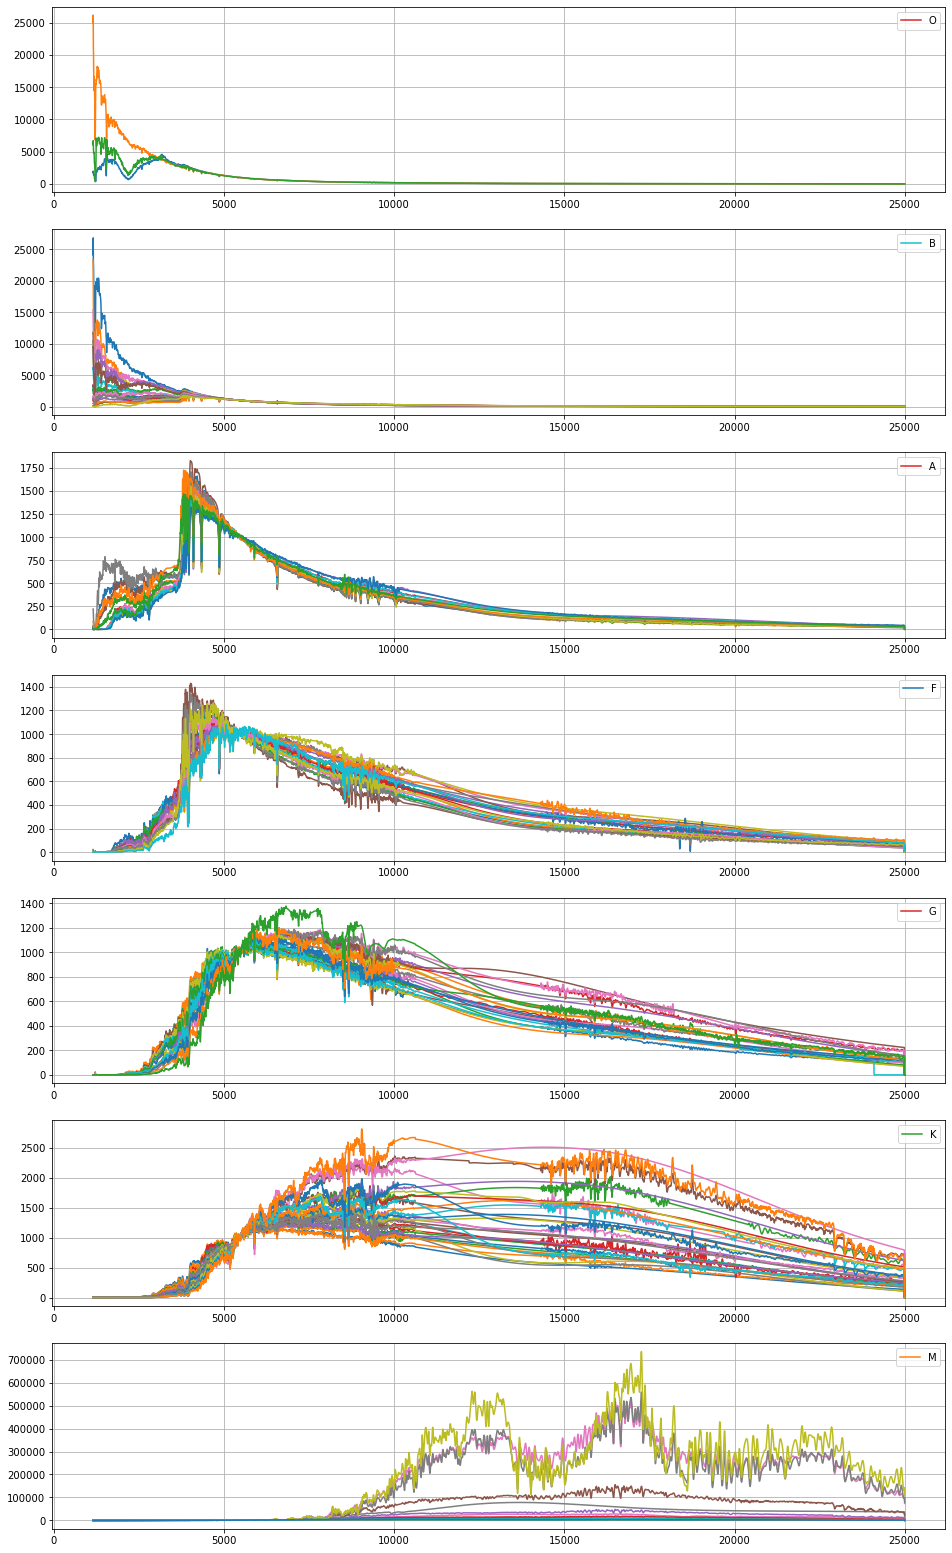

In [52]:
num_rows = len(spectral_types)

fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row in range(num_rows):
    spec_type = spectral_types[row]
    
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            spec = sed_dict[sed_]
            
            axs[row].plot(spec.wave,spec.flux)
    axs[row].plot([],[],label=spec_type)
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].legend()
            

# Load LSST transmissions file 

In [19]:
datafilename = "data/lsst/transmissions-LSST.dat"
df=pd.read_csv(datafilename,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [20]:
wl=df['wl'].values
U=df['U'].values/100.
G=df['G'].values/100.
R=df['R'].values/100.
I=df['I'].values/100.
Z=df['Z'].values/100.
Y4=df['Y4'].values/100.

lsst_bp = []
lsst_bp.append(S.ArrayBandpass(wl*10, U , name="u"))
lsst_bp.append(S.ArrayBandpass(wl*10, G , name="g"))
lsst_bp.append(S.ArrayBandpass(wl*10, R , name="r"))
lsst_bp.append(S.ArrayBandpass(wl*10, I , name="i"))
lsst_bp.append(S.ArrayBandpass(wl*10, Z , name="z"))
lsst_bp.append(S.ArrayBandpass(wl*10, Y4 , name="Y"))

In [21]:
filters = ['U','G','R','I','Z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

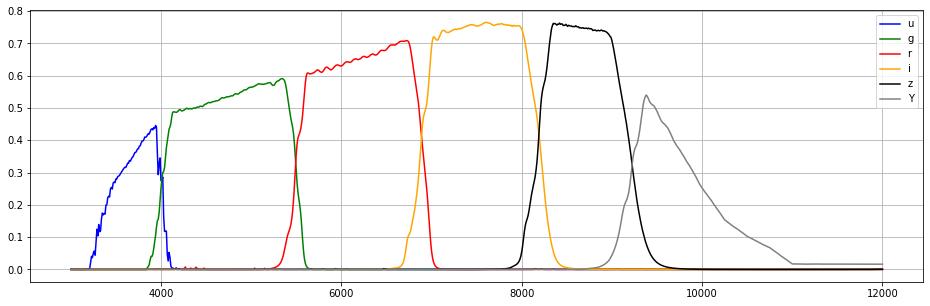

In [22]:
fig=plt.figure(figsize=(16,5))
for index in range(len(lsst_bp)):
    plt.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
plt.grid()
plt.legend()
plt.show()

In [23]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [24]:
wl_lsst = lsst_bp[0].wave

# Load simulated transparencies 

In [25]:
variable_param = 'aerosol'
am0 = 1.99
cloud0 = 0.0

In [26]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)
t_path = './simulated_transparencies'
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [27]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(26, 956)
(2, 956)


In [28]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 25


In [29]:
wl_t = data[0][n_atmp:]*10.

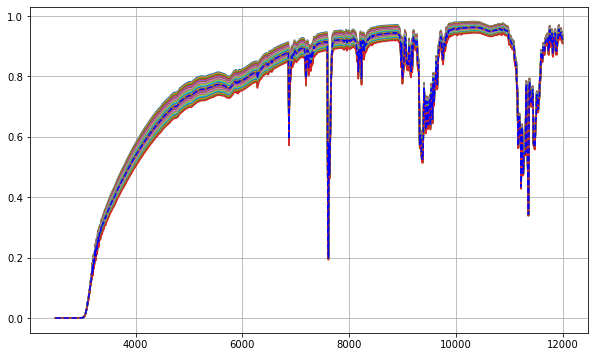

In [30]:
fig=plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:])
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b')
plt.grid()

# Check range of simulated atm values

In [31]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   26                                                  NTRANSP =                   25                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [32]:
data[1:,1]

array([0.01  , 0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275,
       0.03  , 0.0325, 0.035 , 0.0375, 0.04  , 0.0425, 0.045 , 0.0475,
       0.05  , 0.0525, 0.055 , 0.0575, 0.06  , 0.0625, 0.065 , 0.0675,
       0.07  ])

(array([ 0.,  0.,  0.,  0.,  0., 25.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([1.49      , 1.57333333, 1.65666667, 1.74      , 1.82333333,
        1.90666667, 1.99      , 2.07333333, 2.15666667, 2.24      ,
        2.32333333, 2.40666667, 2.49      ]),
 <a list of 12 Patch objects>)

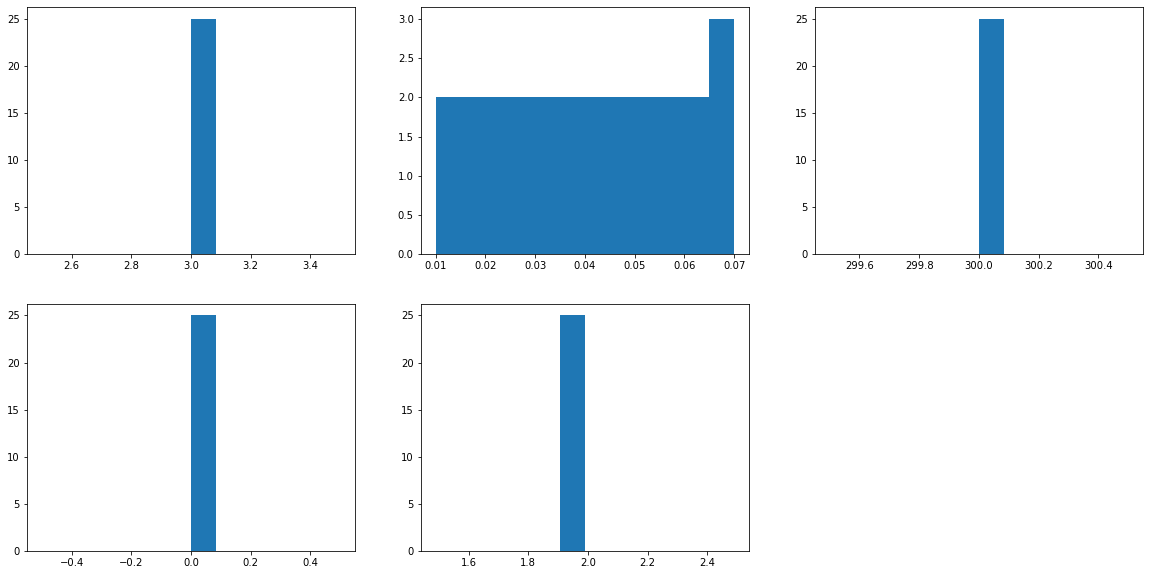

In [33]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234)
ax5=fig.add_subplot(235)

ax1.hist(data[1:,0],bins=12)
ax2.hist(data[1:,1],bins=12)
ax3.hist(data[1:,2],bins=12)
ax4.hist(data[1:,3],bins=12)
ax5.hist(data[1:,4],bins=12)

In [34]:
atm_vals = data[1:,1]

# Convert simulated transparencies into pysynphot format 

In [35]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    atm_transp.append(atm_i)

In [36]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [37]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name.upper()].append(total_pass)

In [38]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name.upper()] = total_pass

In [39]:
print(len(total_passband['U']))
print(total_passband['U'][0])

25
(u * Atm. transp. 1)


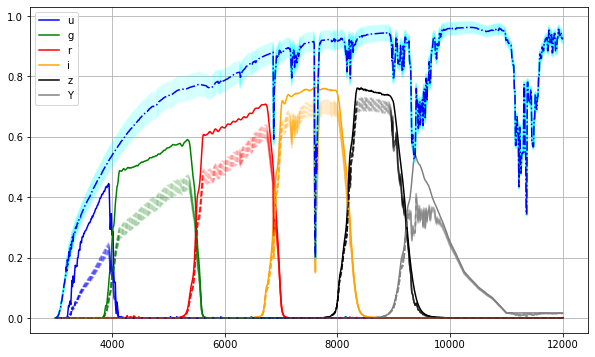

In [40]:
fig=plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.grid()
plt.legend()

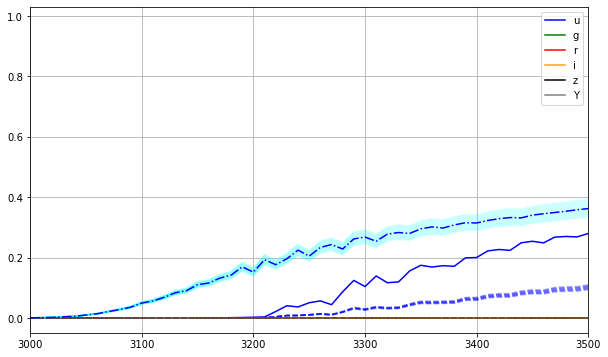

In [41]:
fig=plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(3000.,3500.)
plt.grid()
plt.legend()

(array([3., 2., 3., 2., 2., 3., 2., 3., 2., 3.]),
 array([0.01 , 0.016, 0.022, 0.028, 0.034, 0.04 , 0.046, 0.052, 0.058,
        0.064, 0.07 ]),
 <a list of 10 Patch objects>)

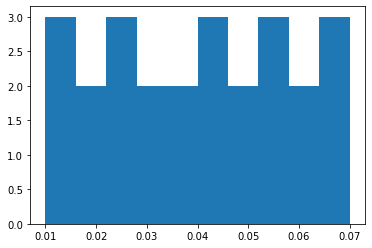

In [42]:
plt.hist(atm_vals)

In [43]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

0.010000000000000002 0.07


In [44]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [45]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

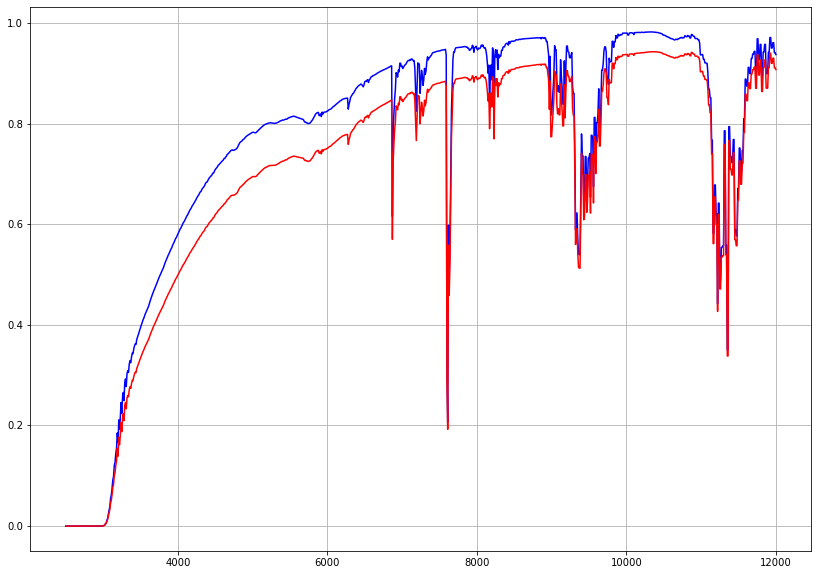

In [46]:
fig=plt.figure(figsize=(14,10))
plt.plot(wl_t,min_transp,color='b')
plt.plot(wl_t,max_transp,color='r')
plt.grid()

/tmp/ipykernel_23471/1989288459.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(wl_t,min_transp/max_transp,color='b')


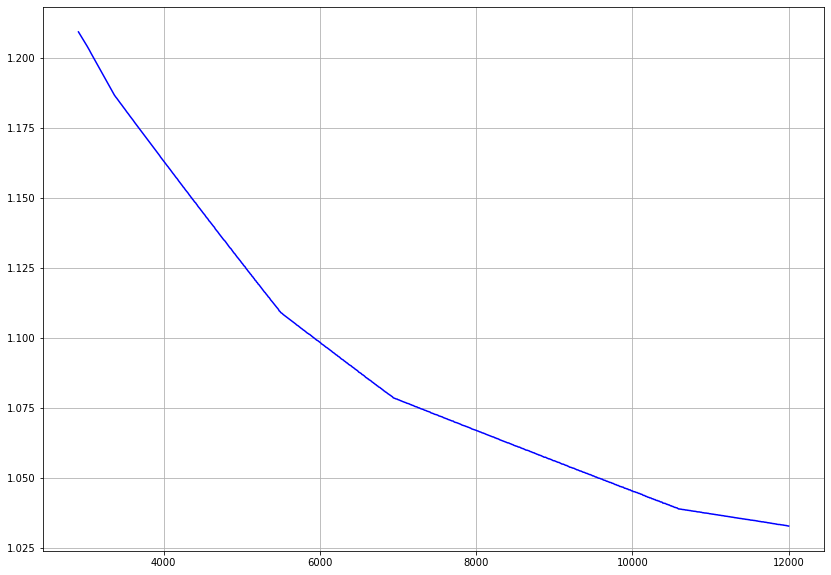

In [47]:
fig=plt.figure(figsize=(14,10))
plt.plot(wl_t,min_transp/max_transp,color='b')
plt.grid()

# Calculate fluxes through total passbands 

In [48]:
# Example with one spectrum (Vega) 
example_spec = 'alpha_lyr_stis_010'
spec = sed_dict[example_spec]
obsatm_dict = {}
for isim in range(n_sim):
    obsatm_dict[isim] = []
    obsatm = S.Observation(spec,atm_transp[isim],force='taper')
    obsatm_dict[isim] = obsatm

obstotal_dict = {}
for filter in filters:
    obstotal_dict[filter] = []

#for filter in lsst_bp:
for filter in filters:
    #print(filter.name.upper())
    for i in range(n_sim):
        #total_pass = filter*atm_transp[i]
        #obs = S.Observation(spec,total_pass,force='taper')
        obstotal = S.Observation(spec,total_passband[filter][i],force='taper')
        obstotal_dict[filter.upper()].append(obstotal)

(Atm. transp. 1) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 3) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 4) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 5) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 6) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 7) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 8) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 9) does not have a defined

((r * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be

U
G
R
I
Z
Y
photlam


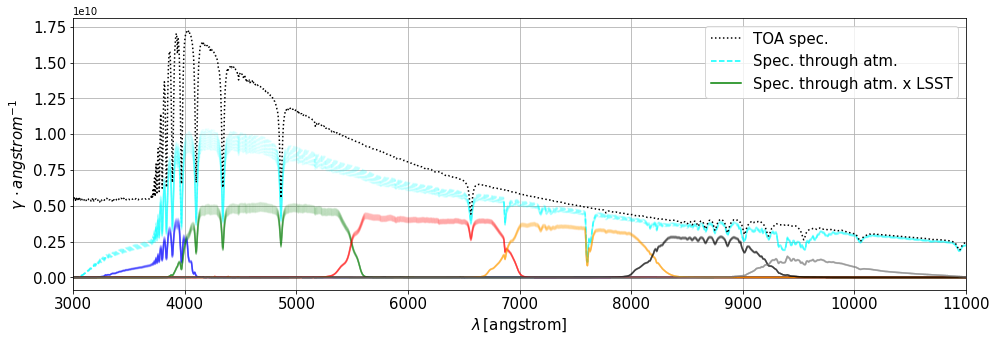

In [49]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    obsatm = obsatm_dict[isim]
    ax.plot(obsatm.binwave,obsatm.binflux*Seff*exptime,ls='--',color='cyan',alpha=0.07)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        #obs.convert('photlam')
        #ax.plot(obs_filter[index].binwave,obs_filter[index].binflux,ls='--',color=filter_colors[index])
        #ax.plot(obs0.binwave,obs0.binflux*Seff*exptime,ls='--',label='Flux through {0}'.format(filter_names[index]),color=filter_colors[index],alpha=0.05)
        #ax.plot(obs.binwave,obsatm.binflux*Seff*exptime,ls='--',label='Flux through {0}'.format(filter_names[index]),color=filter_colors[index],alpha=0.05)
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
plt.plot(spec.wave,spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls=':',color='k',label='TOA spec.')
plt.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

In [50]:
# Spectra (20) through atm x throughput 
obs_dict = {}
for sed_ in list(sed_dict.keys())[:20]:
    spec = sed_dict[sed_]
    
    filter_dict_ = {}
    for filter in filters:
        filter_dict_[filter] = []
        for i in range(n_sim):
            obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
            filter_dict_[filter].append(obs_spec)
    obs_dict[sed_] = filter_dict_ 
    
# Add Vega spectrum to the dictionary 
filter_dict_ = {}
for filter in filters:
    filter_dict_[filter] = []
    for i in range(n_sim):
        obs_spec = S.Observation(sed_dict[example_spec],total_passband[filter][i],force='taper')
        filter_dict_[filter].append(obs_spec)
obs_dict[example_spec] = filter_dict_
    



((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((Y * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be us

((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [51]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(obs_dict[example_spec].keys()))
print(obs_dict[example_spec].keys())
print(len(obs_dict[example_spec]['U']))
print(n_sim)

610
21
6
dict_keys(['U', 'G', 'R', 'I', 'Z', 'Y'])
25
25


In [52]:
# Spectra (20) only through throughput (as if telescope was in space) 
obs_dict_t = {}
for sed_ in list(sed_dict.keys())[:20]:
    spec = sed_dict[sed_]
    
    filter_dict_ = {}
    for filter in lsst_bp:
        obs_spec_t = S.Observation(spec,filter,force='taper')
        filter_dict_[filter.name.upper()] = obs_spec_t
    obs_dict_t[sed_] = filter_dict_ 
    
# Add Vega spectrum to the dictionary 
filter_dict_ = {}
for filter in lsst_bp:
    obs_spec_t = S.Observation(sed_dict[example_spec],filter,force='taper')
    filter_dict_[filter.name.upper()] = obs_spec_t
obs_dict_t[example_spec] = filter_dict_

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in

In [53]:
print(len(sed_dict.keys()))
print(len(obs_dict_t.keys()))
print(len(obs_dict_t[example_spec].keys()))
print(obs_dict_t[example_spec].keys())

610
21
6
dict_keys(['U', 'G', 'R', 'I', 'Z', 'Y'])


In [54]:
obs_dict_t[example_spec]['U']

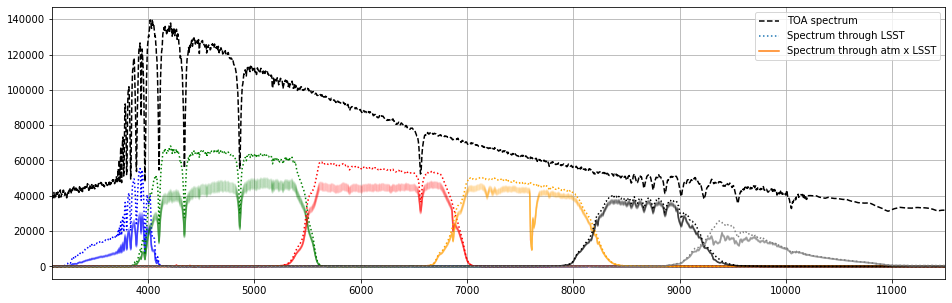

In [55]:
# Check with another spectrum 
example_spec2 = '1740346_stisnic_002'
sed_dict[example_spec2].convert('photlam')
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
#plt.plot(sed_dict[example_spec].wave,sed_dict[example_spec].flux*Seff*exptime,color='b')
plt.plot(sed_dict[example_spec2].wave,sed_dict[example_spec2].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(obs_dict_t[example_spec2][filter].wave,obs_dict_t[example_spec2][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        obs_ = obs_dict[example_spec][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
        obs_2 = obs_dict[example_spec2][filter][i]
        plt.plot(obs_2.wave,obs_2.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
#plt.xlim(WLMIN,WLMAX)
plt.xlim(3100,11500)
plt.grid()
plt.legend()

# Calculate magnitudes (tests with Vega) 

In [56]:
# Start with Vega 
vega_spec = sed_dict[example_spec]
vega_spec.convert('photlam')
print(vega_spec.fluxunits)
#vega_spec.convert('vegamag')
#print(vega_spec.fluxunits)

photlam


In [57]:
# vegamag offers a reasonable approximation to many of the conventional photometric systems that use the spectrum 
# of Vega to define magnitude zero in one or more passbands. In broadband photometry, the relevant passband integral 
# is calculated first for the source spectrum and then again for the spectrum of Vega, and the ratio of the two 
# results is converted to a magnitude. This would not be a scientifically meaningful option for spectrophotometry.

In [58]:
vega_dict_ = {}
for filter in lsst_bp:
    vega_obs_ = S.Observation(vega_spec,filter,force='taper')
    vega_dict_[filter.name.upper()] = vega_obs_

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [59]:
for filter in filters:
    print(vega_dict_[filter].fluxunits)

photlam
photlam
photlam
photlam
photlam
photlam


In [60]:
# This seems quite compatible with zero.... 
for filter in filters:
    print(vega_dict_[filter].effstim('vegamag'))

-1.4885870314174099e-12
-1.8667734025257232e-11
-3.382183422218077e-12
-1.921840464547131e-11
-9.683276402938645e-11
-2.869240844916021e-09


In [61]:
# Flat filter to compare with LSST filters results 
fraction = 1.0
flat_ = np.ones(len(vega_spec.wave))*fraction
flat = S.ArrayBandpass(vega_spec.wave, flat_, name='FlatBandpass')

In [62]:
vega_obsflat = S.Observation(vega_spec,flat,force='taper')

(FlatBandpass) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [63]:
vega_obsflat.effstim('vegamag')

-4.110749074470732e-09

In [64]:
print(vega_obsflat.fluxunits)

photlam


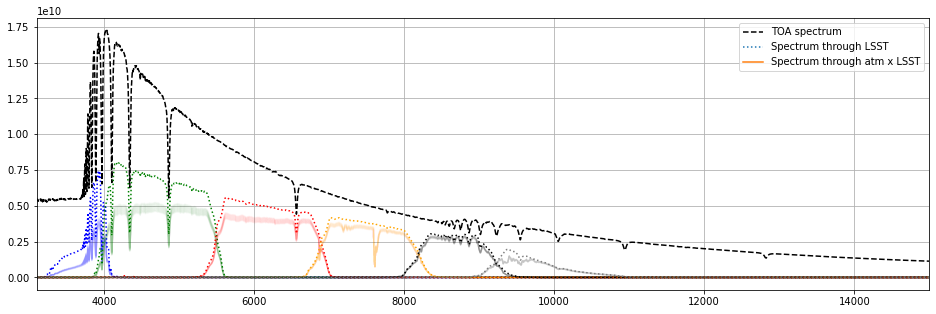

In [65]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
sed_dict[example_spec].convert('photlam')
plt.plot(sed_dict[example_spec].wave,sed_dict[example_spec].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        obs_ = obs_dict[example_spec][filter][i]
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
#plt.xlim(WLMIN,WLMAX)
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(3100,15000)
plt.grid()
plt.legend()

In [66]:
# Magnitudes of Vega passing through atm x throughput 
vega_obs = obs_dict[example_spec]
abmag_dict = {}
vegamag_dict = {}
bad_mag = False
for filter in filters:
    abmag_dict[filter] = []
    for i in range(n_sim):
        try:
            abmag_dict[filter].append(vega_obs[filter][i].effstim("abmag"))
        except:
            bad_mag = True
            pass
        
    print('--------')
    vegamag_dict[filter] = []
    for i in range(n_sim):
        try:
            vegamag_dict[filter].append(vega_obs[filter][i].effstim("vegamag"))
        
        except:
            bad_mag = True
            pass
        

--------
--------
--------
--------
--------
--------


In [67]:
# Magnitudes of spectra passing only through throughput 
vega_obs_t = obs_dict_t[example_spec]

abmag_dict_t = {}
vegamag_dict_t = {}
bad_mag = False
for filter in filters:
    try:
        abmag_dict_t[filter] = vega_obs_t[filter].effstim("abmag")
    except:
        #print(sed_)
        bad_mag = True
        pass
    print('--------')
    try:
        vegamag_dict_t[filter] = vega_obs_t[filter].effstim("vegamag")
    except:
        #print(sed_)
        bad_mag = True
        pass


--------
--------
--------
--------
--------
--------


In [68]:
print(abmag_dict_t)

{'U': 0.5209051002798617, 'G': -0.10484248189391998, 'R': 0.1458491137311153, 'I': 0.3710271433560184, 'Z': 0.5078270096611455, 'Y': 0.41339222834583644}


Text(0, 0.5, 'Y')

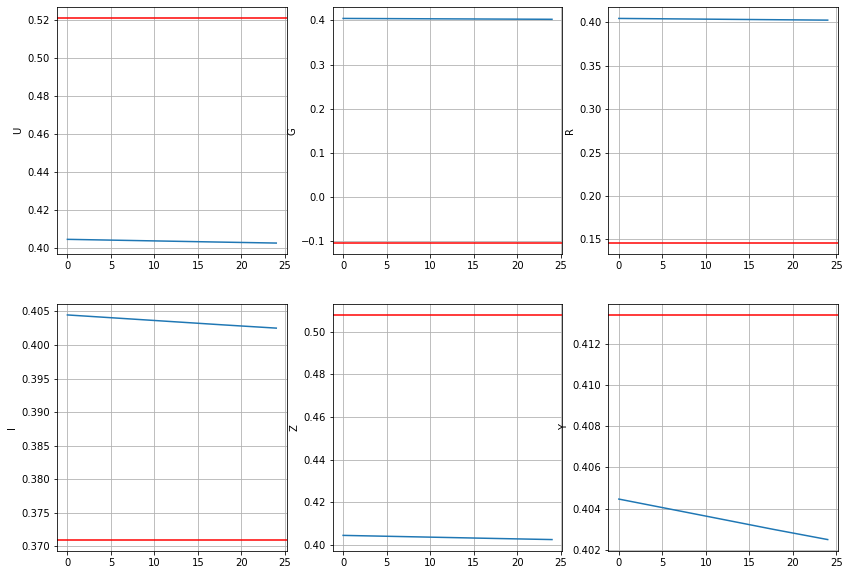

In [69]:
fig = plt.figure(figsize=(14,10))
ax=fig.add_subplot(231)
ax.plot(np.arange(len(abmag_dict['U'])),abmag_dict[filter])
ax.axhline(y=abmag_dict_t['U'],color='r')
ax.grid()
ax.set_ylabel('U')

ax=fig.add_subplot(232)
ax.plot(np.arange(len(abmag_dict['G'])),abmag_dict[filter])
ax.axhline(y=abmag_dict_t['G'],color='r')
ax.grid()
ax.set_ylabel('G')

ax=fig.add_subplot(233)
ax.plot(np.arange(len(abmag_dict['R'])),abmag_dict[filter])
ax.axhline(y=abmag_dict_t['R'],color='r')
ax.grid()
ax.set_ylabel('R')

ax=fig.add_subplot(234)
ax.plot(np.arange(len(abmag_dict['I'])),abmag_dict[filter])
ax.axhline(y=abmag_dict_t['I'],color='r')
ax.grid()
ax.set_ylabel('I')

ax=fig.add_subplot(235)
ax.plot(np.arange(len(abmag_dict['Z'])),abmag_dict[filter])
ax.axhline(y=abmag_dict_t['Z'],color='r')
ax.grid()
ax.set_ylabel('Z')

ax=fig.add_subplot(236)
ax.plot(np.arange(len(abmag_dict['Y'])),abmag_dict[filter])
ax.axhline(y=abmag_dict_t['Y'],color='r')
ax.grid()
ax.set_ylabel('Y')

# Calculate magnitudes with my own function 

Physical constants 

In [70]:
c = S.units.C #speed of light [Angstrom /s] 
print(c)
h = S.units.H #Planck's constant [erg*s] 
print(h)

2.99792458e+18
6.6262e-27


In [71]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [72]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [73]:
C = f_ref/(h*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [74]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

In [75]:
def myAB(spec,passband,filter):
    f_units = str(spec.fluxunits)
    if f_units!='flam':
        print('ATTENTION: converting flux units to flam')
        spec.convert('flam')
        
    observation = S.Observation(spec,passband,force='taper')
    num = np.trapz(observation.flux/observation.wave,x=observation.wave)
    #obmag = -2.5*np.log10(num)
    
    spec.convert('photlam')
    
    #print(num)
    
    #flatsp = S.FlatSpectrum(f_ref,fluxunits='fnu')
    #flatsp_vals = np.ones(len(spec.wave))*f_ref
    #flatsp = S.ArraySpectrum(spec.wave,flatsp_vals)
    
    flatsp_nphot = ABnphot(spec.wave)
    flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')
    
    flatsp_.convert('flam')
    ab_obs = S.Observation(flatsp_,filter,force='taper')
    den = np.trapz(ab_obs.flux/ab_obs.wave,x=ab_obs.wave)
    
    #print(den)
    #print(num/den)
    #print(obmag)
    mab = -2.5*np.log10(num/den)
    print(mab)
    return mab

In [76]:
# This function gives the flux of an AB source in photons / s / cm^2 / Angstrom 
flatsp_nphot = ABnphot(vega_spec.wave)

In [77]:
#Let's write this in pysynphot format (note that the result will be in photlam units, then we use ABnphot as input)
flatsp = S.ArraySpectrum(vega_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [78]:
flatsp.fluxunits

photlam


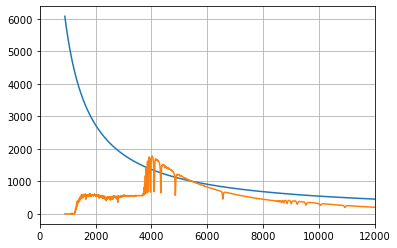

In [79]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
vega_spec.convert('photlam')
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(vega_spec.wave,vega_spec.flux)
plt.xlim(0.,12000.)
plt.grid()

In [80]:
flatsp0 = S.FlatSpectrum(f_ref,fluxunits='fnu')
flatsp0.fluxunits

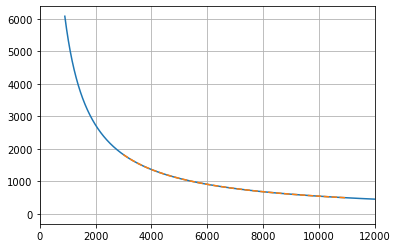

In [81]:
# Here we verify that creating a pysynphot AB flat spectrum and transforming it to photlam gives the same as 
# directly creating the same spectrum in photlam units with ABnphot 
flatsp0.convert('photlam')
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(flatsp0.wave,flatsp0.flux,ls='--')
plt.xlim(0.,12000.)
plt.grid()

To further check it, let's transform it to flam and compare with the analytical expression: 

$$F_{\lambda} = F_{\nu} \frac{c}{\lambda^2}$$

In [82]:
flambda = f_ref*c/flatsp.wave**2.

In [83]:
flatsp.convert('flam')
flatsp.waveunits

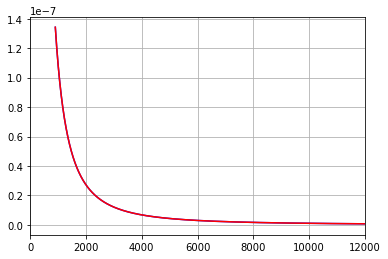

In [84]:
plt.plot(flatsp.wave,flatsp.flux,color='b')
plt.plot(flatsp.wave,flambda,color='r')
plt.xlim(0.,12000.)
plt.grid()
flatsp.convert('photlam')

Now we check that the AB magnitudes are zero for the flat AB spectrum (they have to be through any filter, by definition) 

In [85]:
for filter in lsst_bp:
    myAB(flatsp,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of 

We check the same for the total passband 

In [86]:
for fi,filter in enumerate(filters):
    myAB(flatsp,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9326213659140548
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.36076352964524305
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1850224612733535
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The

Now, let's see the AB magnitudes of Vega with myAB function. To better understand it, compare the AB spectrum and Vega spectrum flux amplitudes in each range of wavelengths (see plot below) 

photlam


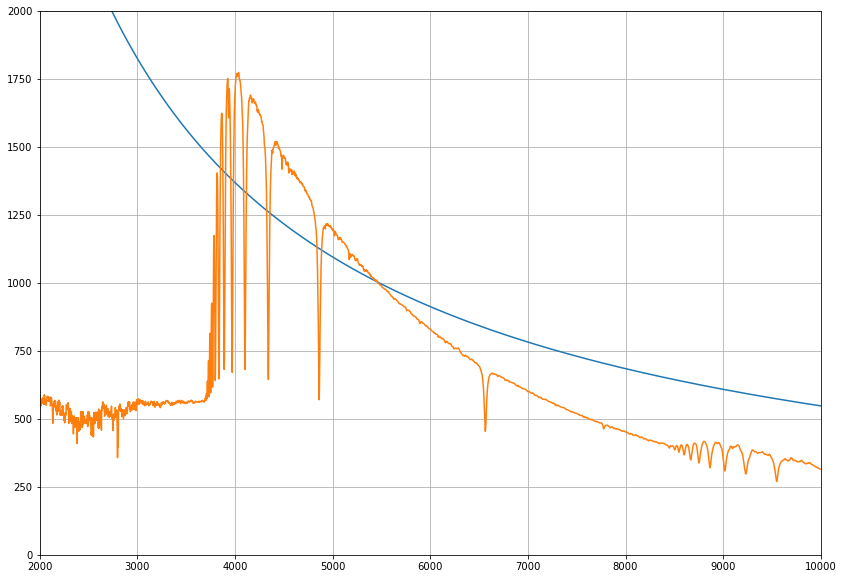

In [87]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
vega_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(vega_spec.wave,vega_spec.flux)
plt.xlim(2000.,10000.)
plt.ylim(0.,2000.)
plt.grid()

In [88]:
for filter in lsst_bp:
    myAB(vega_spec,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6534927209069824
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11342226644888148
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13345518503434384
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined

In [89]:
for fi,filter in enumerate(filters):
    myAB(vega_spec,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4277075277690847
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2516692493238953
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.32204907240994707
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The

# Calculate magnitudes and colours

In [90]:
# Magnitudes of spectra passing through atm x throughput 
mag_dict = {}
mag_dict_ref = {}
for sed_ in list(sed_dict.keys())[:20]:
    obs_spec_ = sed_dict[sed_]
    
    mag_dict_ = {}
    mag_dict_ref_ = {}
    bad_mag = False
    for fi,filter in enumerate(filters):
        mag_dict_[filter] = []
        for i in range(n_sim):
            try:
                #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
                mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
                mag_dict_[filter].append(mag_ab_)
            
            except:
                #print(sed_)
                bad_mag = True
                pass
            
            if bad_mag==False:
                mag_dict[sed_] = mag_dict_
                
        mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
        mag_dict_ref_[filter] = mag_ab_
    mag_dict_ref[sed_] = mag_dict_ref_
        
# Add Vega to the dictionary
bad_mag = False
mag_dict_ = {}
mag_dict_ref_ = {}
for fi,filter in enumerate(filters):
    mag_dict_[filter] = []
    for i in range(n_sim):
        try:
            mag_ab_ = myAB(sed_dict[example_spec],total_passband[filter][i],lsst_bp[fi])
            mag_dict_[filter].append(mag_ab_)
        except:
            bad_mag = True
            pass
        if bad_mag==False:
            mag_dict[example_spec] = mag_dict_
            
    mag_ab_ = myAB(sed_dict[example_spec],total_passband_ref[filter],lsst_bp[fi])
    mag_dict_ref_[filter] = mag_ab_
mag_dict_ref[example_spec] = mag_dict_ref_

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.036863821827358
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.044061460074266
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.051258981207898
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The 

((g * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.836842768481327
ATTENTION: converting flux units to flam
((g * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.842543439164247
ATTENTION: converting flux units to flam
((g * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.848231788946762
ATTENTION: converting flux units to flam
((g * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

8.815812891344919
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.818949944063533
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.822086949641383
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.82522391795398
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavec

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.707600094144329
ATTENTION: converting flux units to flam
((z * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.710191485577264
ATTENTION: converting flux units to flam
((z * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.712822077945544
ATTENTION: converting flux units to flam
((z * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.715567759905

8.784088753551453
ATTENTION: converting flux units to flam
((Y * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.786303653119331
ATTENTION: converting flux units to flam
((Y * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.788516400850376
ATTENTION: converting flux units to flam
((Y * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.790727383820174
ATTENTION: converting flux units to flam
((Y * Atm. transp. 25)) does not have a defined binset in the 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.870847857076006
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.876666130529424
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.88248404197587
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.888301592945

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.755470602667632
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.75862391891122
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.761777216945108
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.764930463189

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.833910884177467
ATTENTION: converting flux units to flam
((z * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.836510558247538
ATTENTION: converting flux units to flam
((z * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.839110170548853
ATTENTION: converting flux units to flam
((z * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.84170976

((Y * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.035409865655934
ATTENTION: converting flux units to flam
((Y * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.0376534382211
ATTENTION: converting flux units to flam
((Y * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.039895248420102
ATTENTION: converting flux units to flam
((Y * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.447962136356065
ATTENTION: converting flux units to flam
((g * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.453680817032275
ATTENTION: converting flux units to flam
((g * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.459399147233054
ATTENTION: converting flux units to flam
((g * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.465117129820

7.901467388685956
ATTENTION: converting flux units to flam
((r * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.9055510597287775
ATTENTION: converting flux units to flam
((r * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.909652615011776
ATTENTION: converting flux units to flam
((r * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.91380700719856
ATTENTION: converting flux units to flam
((r * Atm. transp. 21)) does not have a defined binset in the 

7.734066705308571
ATTENTION: converting flux units to flam
((i * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.737328386485159
ATTENTION: converting flux units to flam
((i * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.740594012077259
ATTENTION: converting flux units to flam
((i * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.743858236222698
ATTENTION: converting flux units to flam
((i * Atm. transp. 24)) does not have a defined binset in the 

7.784279706784279
ATTENTION: converting flux units to flam
((Y * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.78632134842867
ATTENTION: converting flux units to flam
((Y * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.788362914547443
ATTENTION: converting flux units to flam
((Y * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.790404397967875
ATTENTION: converting flux units to flam
((Y * Atm. transp. 14)) does not have a defined binset in the w

11.32844797675704
ATTENTION: converting flux units to flam
((u * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.335554815758776
ATTENTION: converting flux units to flam
((u * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.34266263621875
ATTENTION: converting flux units to flam
((u * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.349771243665591
ATTENTION: converting flux units to flam
((u * Atm. transp. 25)) does not have a defined binset in th

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.142118760520706
ATTENTION: converting flux units to flam
((g * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.147848407783592
ATTENTION: converting flux units to flam
((g * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.078961324473234
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.5490065510

((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.392874833950112
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.39601781834153
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.399160764106163
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.

((z * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.372555616603007
ATTENTION: converting flux units to flam
((z * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.375305072224771
ATTENTION: converting flux units to flam
((z * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.378052777806397
ATTENTION: converting flux units to flam
((z * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
18.267992215553573
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
18.27525708186753
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
18.28252182639874
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
18.2897864923551

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.454379532957432
ATTENTION: converting flux units to flam
((g * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.46018779935025
ATTENTION: converting flux units to flam
((g * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.465995683744584
ATTENTION: converting flux units to flam
((g * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.471803236

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.448411596936538
ATTENTION: converting flux units to flam
((r * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.45262908045025
ATTENTION: converting flux units to flam
((r * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.456844238877952
ATTENTION: converting flux units to flam
((r * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.461061461

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.65814419898509
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.660754236374466
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.663364242701558
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.665974206938

17.754288220899046
ATTENTION: converting flux units to flam
((Y * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.756428118576707
ATTENTION: converting flux units to flam
((Y * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.758567956402572
ATTENTION: converting flux units to flam
((Y * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
17.760707707949166
ATTENTION: converting flux units to flam
((Y * Atm. transp. 14)) does not have a defined binset in 

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.119407030082353
ATTENTION: converting flux units to flam
((u * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.126607339545114
ATTENTION: converting flux units to flam
((u * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.133808696789771
ATTENTION: converting flux units to flam
((u * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.14101089

((g * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.982623751713549
ATTENTION: converting flux units to flam
((g * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.911642122946944
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.190576224786575
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.549367670622516
ATTENTION: converting flux units to flam
((i * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.552546670477614
ATTENTION: converting flux units to flam
((i * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.555725549970001
ATTENTION: converting flux units to flam
((i * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.55890437

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.803962682081536
ATTENTION: converting flux units to flam
((z * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.806578907034933
ATTENTION: converting flux units to flam
((z * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.80919509121236
ATTENTION: converting flux units to flam
((z * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.811811196

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.111427043814707
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.118693618554769
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.125960081883512
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.13322646571

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.603726274838564
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.609575312759109
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.615423980921186
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.62127228460

((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.591896847464543
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.596021351675708
ATTENTION: converting flux units to flam
((r * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.600145720496464
ATTENTION: converting flux units to flam
((r * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

12.718162707121824
ATTENTION: converting flux units to flam
((i * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.72132290647628
ATTENTION: converting flux units to flam
((i * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.724483036500798
ATTENTION: converting flux units to flam
((i * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.7276431075885
ATTENTION: converting flux units to flam
((i * Atm. transp. 19)) does not have a defined binset in the

((z * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.85070842960046
ATTENTION: converting flux units to flam
((z * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.853353717542861
ATTENTION: converting flux units to flam
((z * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.85611346483396
ATTENTION: converting flux units to flam
((z * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

((Y * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.178177302046665
ATTENTION: converting flux units to flam
((Y * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.180435436641336
ATTENTION: converting flux units to flam
((Y * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.182698433940372
ATTENTION: converting flux units to flam
((Y * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used 

((g * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.97094127330309
ATTENTION: converting flux units to flam
((g * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.976869961126301
ATTENTION: converting flux units to flam
((g * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.982798261662289
ATTENTION: converting flux units to flam
((g * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.303642712543294
ATTENTION: converting flux units to flam
((r * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.307862762558525
ATTENTION: converting flux units to flam
((r * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.312080481152897
ATTENTION: converting flux units to flam
((r * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.31630024

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.769878708761112
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.772496014379126
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.775113243612426
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.77773044135

13.101867890205472
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.104063164092171
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.106258276084597
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.108453245399721
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the 

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.04618442588962545
ATTENTION: converting flux units to flam
((u * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03902919869478348
ATTENTION: converting flux units to flam
((u * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03187408733169413
ATTENTION: converting flux units to flam
((u * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.02

-1.079844142177542
ATTENTION: converting flux units to flam
((g * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.150046241256257
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.142336147562293
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.1381982504719415
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in th

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9366274546111752
ATTENTION: converting flux units to flam
((i * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9334676306724412
ATTENTION: converting flux units to flam
((i * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9303078429720137
ATTENTION: converting flux units to flam
((i * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.92714

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6360286666936186
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6339502263698578
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6318719036345034
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.62979367

11.526001984586731
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.968382922353584
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.974283198437744
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.980183132097478
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.185872860494847
ATTENTION: converting flux units to flam
((r * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.190015114510805
ATTENTION: converting flux units to flam
((r * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.194157214455082
ATTENTION: converting flux units to flam
((r * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.19829918

11.44022442748337
ATTENTION: converting flux units to flam
((i * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.443392276966108
ATTENTION: converting flux units to flam
((i * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.446590972813638
ATTENTION: converting flux units to flam
((i * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.449880389993092
ATTENTION: converting flux units to flam
((i * Atm. transp. 21)) does not have a defined binset in t

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.680639271961525
ATTENTION: converting flux units to flam
((Y * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.683212069594244
ATTENTION: converting flux units to flam
((Y * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.68578424916064
ATTENTION: converting flux units to flam
((Y * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.688355847

15.850059390467719
ATTENTION: converting flux units to flam
((u * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.857233488342697
ATTENTION: converting flux units to flam
((u * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.8643364799045
ATTENTION: converting flux units to flam
((u * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.871442522834954
ATTENTION: converting flux units to flam
((u * Atm. transp. 22)) does not have a defined binset in th

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.243158153032745
ATTENTION: converting flux units to flam
((g * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.248833945604705
ATTENTION: converting flux units to flam
((g * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.254509580649337
ATTENTION: converting flux units to flam
((g * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.26018507

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.318616997784993
ATTENTION: converting flux units to flam
((i * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.321757333268296
ATTENTION: converting flux units to flam
((i * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.324897606008836
ATTENTION: converting flux units to flam
((i * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.32803787

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.246544494197972
ATTENTION: converting flux units to flam
((z * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.249138955972937
ATTENTION: converting flux units to flam
((z * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.251733363874942
ATTENTION: converting flux units to flam
((z * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.25432776

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.345270901630622
ATTENTION: converting flux units to flam
((Y * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.347310124601693
ATTENTION: converting flux units to flam
((Y * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.349349270068664
ATTENTION: converting flux units to flam
((Y * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.35143538

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.080727913175382
ATTENTION: converting flux units to flam
((g * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.086632517018428
ATTENTION: converting flux units to flam
((g * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.092537720606533
ATTENTION: converting flux units to flam
((g * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.09844168

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.41969300896686
ATTENTION: converting flux units to flam
((r * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.423915081205433
ATTENTION: converting flux units to flam
((r * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.428136270310809
ATTENTION: converting flux units to flam
((r * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.432356701

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.94322584304641
ATTENTION: converting flux units to flam
((z * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.945842863061042
ATTENTION: converting flux units to flam
((z * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.94845981402787
ATTENTION: converting flux units to flam
((z * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.9510767227

((Y * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.339359589968167
ATTENTION: converting flux units to flam
((Y * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.34146935723778
ATTENTION: converting flux units to flam
((Y * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.343578950882133
ATTENTION: converting flux units to flam
((Y * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.456839789943473
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.911674049224342
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.917544143355709
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.026871076344484
ATTENTION: converting flux units to flam
((r * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.031000966443527
ATTENTION: converting flux units to flam
((r * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.035130713935096
ATTENTION: converting flux units to flam
((r * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.03926030

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.182454796837632
ATTENTION: converting flux units to flam
((i * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.185618074554693
ATTENTION: converting flux units to flam
((i * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.188781277002047
ATTENTION: converting flux units to flam
((i * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.19194441

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.340041273625806
ATTENTION: converting flux units to flam
((z * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.342649701752268
ATTENTION: converting flux units to flam
((z * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.345297076726702
ATTENTION: converting flux units to flam
((z * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
15.34805882

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.486459194063936
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.493612708609943
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.500766119597456
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.507919471986215

((g * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.249771301215065
ATTENTION: converting flux units to flam
((g * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.255599658635999
ATTENTION: converting flux units to flam
((g * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.261427667799834
ATTENTION: converting flux units to flam
((g * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

((r * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.189825981609378
ATTENTION: converting flux units to flam
((r * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.194016818083531
ATTENTION: converting flux units to flam
((r * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.198209763892903
ATTENTION: converting flux units to flam
((r * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.322776224971107
ATTENTION: converting flux units to flam
((z * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.32553062649986
ATTENTION: converting flux units to flam
((z * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.328279972772669
ATTENTION: converting flux units to flam
((z * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
7.3310342653777

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.098046182602626
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.105192692425732
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.112339135322134
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.11948551228

9.966053137597832
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.97191268957674
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.977771877619956
ATTENTION: converting flux units to flam
((g * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.98363071358365
ATTENTION: converting flux units to flam
((g * Atm. transp. 11)) does not have a defined binset in the wave

10.04914141877201
ATTENTION: converting flux units to flam
((r * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.053341792932748
ATTENTION: converting flux units to flam
((r * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.05753980473444
ATTENTION: converting flux units to flam
((r * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.061739910497927
ATTENTION: converting flux units to flam
((r * Atm. transp. 23)) does not have a defined binset in th

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.191873908595824
ATTENTION: converting flux units to flam
((i * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.195151967196594
ATTENTION: converting flux units to flam
((i * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.198433291699036
ATTENTION: converting flux units to flam
((i * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.15977314

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.43043919730028
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.432515109739862
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.434590931192929
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.436666638508

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.797296152996498
ATTENTION: converting flux units to flam
((u * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.80449869550835
ATTENTION: converting flux units to flam
((u * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.811704472970971
ATTENTION: converting flux units to flam
((u * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.818906898

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.680693717405882
ATTENTION: converting flux units to flam
((g * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.686598661918605
ATTENTION: converting flux units to flam
((g * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.692503583619978
ATTENTION: converting flux units to flam
((g * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.69840737

11.283392926054287
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.28657367855544
ATTENTION: converting flux units to flam
((i * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.289754326919443
ATTENTION: converting flux units to flam
((i * Atm. transp. 11)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.292934879233199
ATTENTION: converting flux units to flam
((i * Atm. transp. 12)) does not have a defined binset in th

((z * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.549669619103506
ATTENTION: converting flux units to flam
((z * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.552287567503507
ATTENTION: converting flux units to flam
((z * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.554905452965421
ATTENTION: converting flux units to flam
((z * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used 

((Y * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.914810976864267
ATTENTION: converting flux units to flam
((Y * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.917182011215978
ATTENTION: converting flux units to flam
((Y * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.889761518103363
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.947476921115882
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.95303310180388
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.958588946253496
ATTENTION: converting flux units to flam
((g * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.96414445691

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.847107667947006
ATTENTION: converting flux units to flam
((r * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.85115308039662
ATTENTION: converting flux units to flam
((r * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.855198362702579
ATTENTION: converting flux units to flam
((r * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.859243505

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.179529989593368
ATTENTION: converting flux units to flam
((z * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.182116190546814
ATTENTION: converting flux units to flam
((z * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.184702353888254
ATTENTION: converting flux units to flam
((z * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.18728848

((Y * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.177394433272616
ATTENTION: converting flux units to flam
((Y * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.179584783465188
ATTENTION: converting flux units to flam
((Y * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.181772964521969
ATTENTION: converting flux units to flam
((Y * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used 

12.066176643808358
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.833973670494718
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.839907352426522
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.845840696383867
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.258742706620755
ATTENTION: converting flux units to flam
((r * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.262964565948256
ATTENTION: converting flux units to flam
((r * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.26718554280116
ATTENTION: converting flux units to flam
((r * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.271405762

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.729711536213891
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.73234117189692
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.734970730677652
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.737600257732

((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.86362136390203
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.866274658826287
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.868927128495933
ATTENTION: converting flux units to flam
((Y * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

9.79307917914709
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.798833380951411
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.80458721280609
ATTENTION: converting flux units to flam
((g * Atm. transp. 10)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.810340684425414
ATTENTION: converting flux units to flam
((g * Atm. transp. 11)) does not have a defined binset in the wave

((r * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.350650786431437
ATTENTION: converting flux units to flam
((r * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.354738761505697
ATTENTION: converting flux units to flam
((r * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.358826605386094
ATTENTION: converting flux units to flam
((r * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

((i * Atm. transp. 22)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.208964353620722
ATTENTION: converting flux units to flam
((i * Atm. transp. 23)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.212228758422492
ATTENTION: converting flux units to flam
((i * Atm. transp. 24)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.215491995546685
ATTENTION: converting flux units to flam
((i * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

((z * Atm. transp. 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.118123212987557
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.229488656887922
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.2315326966224
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.215012090304954
ATTENTION: converting flux units to flam
((u * Atm. transp. 12)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.222312717181662
ATTENTION: converting flux units to flam
((u * Atm. transp. 13)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.229613235231046
ATTENTION: converting flux units to flam
((u * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.23691370

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.088072462849631
ATTENTION: converting flux units to flam
((g * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.093990548962564
ATTENTION: converting flux units to flam
((g * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.09988760946624
ATTENTION: converting flux units to flam
((g * Atm. transp. 21)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.105785255

13.659394280009954
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.662572921998857
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.665751464363433
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.668929911825353
ATTENTION: converting flux units to flam
((i * Atm. transp. 10)) does not have a defined binset in the

((z * Atm. transp. 14)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.923516113301169
ATTENTION: converting flux units to flam
((z * Atm. transp. 15)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.926133039319756
ATTENTION: converting flux units to flam
((z * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.928749882324137
ATTENTION: converting flux units to flam
((z * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used 

((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4277075277690847
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.434852437010433
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.441997239012106
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instea

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.33378538445965644
ATTENTION: converting flux units to flam
((g * Atm. transp. 16)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.33964810210438284
ATTENTION: converting flux units to flam
((g * Atm. transp. 17)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.34551048071158197
ATTENTION: converting flux units to flam
((g * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.351372

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.49191116778675775
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.49507111421518807
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.498231037408837
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.50139090365

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6237521074579264
ATTENTION: converting flux units to flam
((z * Atm. transp. 18)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6263533000866622
ATTENTION: converting flux units to flam
((z * Atm. transp. 19)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.628993543388501
ATTENTION: converting flux units to flam
((z * Atm. transp. 20)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6317484615

In [91]:
print(len(obs_dict.keys()))
print(len(mag_dict.keys()))
print(len(mag_dict[example_spec]['U']))
print(mag_dict[example_spec]['U'])
print(mag_dict[example_spec]['G'])

21
21
25
[1.4277075277690847, 1.434852437010433, 1.441997239012106, 1.449141974515087, 1.456286645207467, 1.4634312171695814, 1.4705757366606185, 1.4777201529807191, 1.4848644885177387, 1.4920087777034075, 1.4991530049819368, 1.506297117848063, 1.5134411402245826, 1.5205851059471933, 1.5277290156789822, 1.5348728149339008, 1.5420165731994548, 1.5491601958852868, 1.5562803549963307, 1.5633315748191554, 1.5703857795274327, 1.5774369108688893, 1.5844889933485362, 1.5915418500726506, 1.5985921456990573]
[0.2516692493238953, 0.2575370234869604, 0.26340445769388454, 0.2692715215111751, 0.2751382210247904, 0.28100456096088905, 0.28687054080696245, 0.2927361584015364, 0.2986014119633578, 0.30446631350569364, 0.310330853660973, 0.31619502284956746, 0.322058828576139, 0.32792228056960726, 0.33378538445965644, 0.33964810210438284, 0.34551048071158197, 0.3513724680016177, 0.3572279093198608, 0.36306483397013156, 0.36890222812210427, 0.3747385107741078, 0.38057472827281086, 0.3864108826750442, 0.39

In [92]:
print(len(obs_dict.keys()))
print(len(mag_dict_ref.keys()))
mag_dict_ref[example_spec]

21
21


{'U': 1.5134411402245826,
 'G': 0.322058828576139,
 'R': 0.37167967351576797,
 'I': 0.5235085547032822,
 'Z': 0.6133468583114161,
 'Y': 0.8219879186024803}

In [93]:
# Magnitudes of spectra passing only through throughput 
mag_dict_t = {}
for sed_ in list(sed_dict.keys())[:20]:
    obs_spec_ = sed_dict[sed_]
    
    mag_dict_ = {}
    bad_mag = False
    for index,filter in enumerate(lsst_bp):
        try:
            #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
            mag_ab_ = myAB(obs_spec_,lsst_bp[index],lsst_bp[index])
            mag_dict_[filters[index]] = mag_ab_
        except:
            #print(sed_)
            bad_mag = True
            pass
    if bad_mag==False:
        mag_dict_t[sed_] = mag_dict_
        
# Add Vega to dictionary 
bad_mag = False
mag_dict_ = {}
for index,filter in enumerate(lsst_bp):
    try:
        mag_ab_ = myAB(sed_dict[example_spec],lsst_bp[index],lsst_bp[index])
        mag_dict_[filters[index]] = mag_ab_
    except:
        bad_mag = True
        pass
    if bad_mag==False:
        mag_dict_t[example_spec] = mag_dict_
        

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
10.24046980053948
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
9.40046526485429
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
8.9096403140104
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset i

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.46290694247719
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.999606556172981
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.334455829314985
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
12.69881599204737
ATTENTION: converting flux units to flam
(Y) does not 

13.313388164053666
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.17748112353771
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.143983359274289
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
13.145626241544285
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.45240187130111
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
11.662695214724552
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
16.76274745447015
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
14.601119076384455
ATTENTION: converting flux units to flam
(r) does not 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5127239300473972
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6200137158948859


In [94]:
print(len(obs_dict.keys()))
print(len(mag_dict_t.keys()))
print(mag_dict_t[example_spec]['U'])
print(mag_dict_t[example_spec]['G'])

21
21
0.6534927209069824
-0.11342226644888148


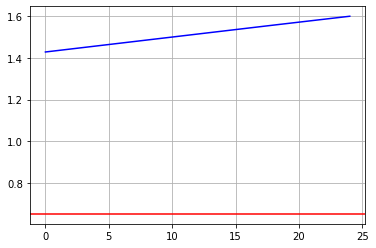

In [95]:
band = 'U'
plt.plot(np.arange(len(mag_dict[example_spec][band])),mag_dict[example_spec][band],color='b')
plt.axhline(y=mag_dict_t[example_spec][band],color='r')
plt.grid()

In [96]:
print(filters)

['U', 'G', 'R', 'I', 'Z', 'Y']


In [97]:
colour_dict = {}
for sed_ in mag_dict.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(mag_dict[sed_][filters[fi]])
        mag2 = np.array(mag_dict[sed_][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    colour_dict[sed_] = c_dict

In [98]:
print(len(mag_dict.keys()))
print(len(colour_dict.keys()))
print(colour_dict[example_spec].keys())
print(colour_dict[example_spec]['u-g'])
print(len(colour_dict[example_spec]['u-g']))

21
21
dict_keys(['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
[1.17603828 1.17731541 1.17859278 1.17987045 1.18114842 1.18242666
 1.1837052  1.18498399 1.18626308 1.18754246 1.18882215 1.19010209
 1.19138231 1.19266283 1.19394363 1.19522471 1.19650609 1.19778773
 1.19905245 1.20026674 1.20148355 1.2026984  1.20391427 1.20513097
 1.20634614]
25


In [99]:
colour_dict_ref = {}
for sed_ in mag_dict_ref.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(mag_dict_ref[sed_][filters[fi]])
        mag2 = np.array(mag_dict_ref[sed_][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    colour_dict_ref[sed_] = c_dict

In [100]:
print(len(mag_dict_ref.keys()))
print(len(colour_dict_ref.keys()))
print(colour_dict_ref[example_spec].keys())
print(colour_dict_ref[example_spec]['u-g'])

21
21
dict_keys(['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
1.1913823116484437


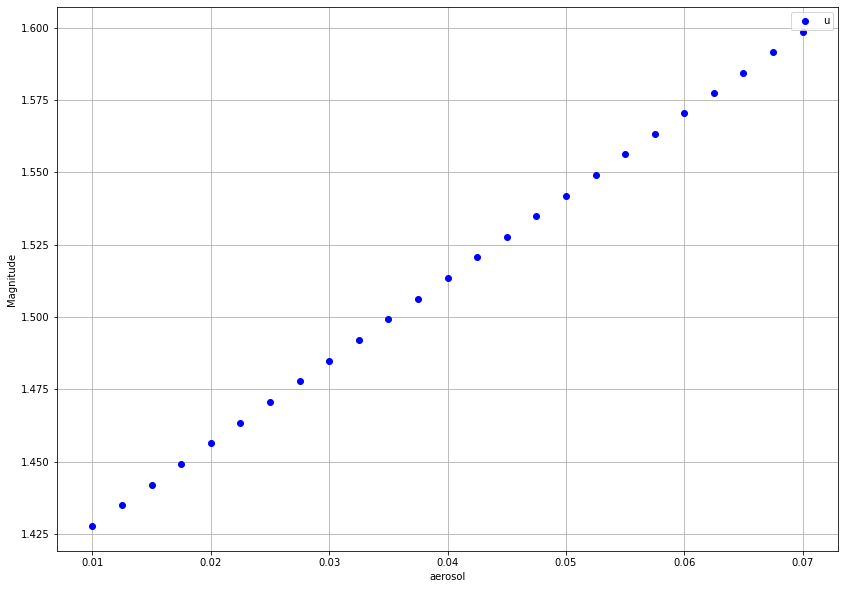

In [101]:
band = 'u'
plt.figure(figsize=(14,10))
plt.plot(atm_vals,mag_dict[example_spec][band.upper()],ls='',marker='o',color='b',label=band)
#plt.plot(atm_vals,mag_dict[example_spec]['G'],ls='',marker='o',color='orange',label='g')
#plt.plot(atm_vals,mag_dict[example_spec]['R'],ls='',marker='o',color='r',label='r')
#plt.plot(atm_vals,mag_dict[example_spec]['I'],ls='',marker='o',color='r',label='i')
#plt.plot(atm_vals,mag_dict[example_spec]['Z'],ls='',marker='o',color='r',label='z')
#plt.plot(atm_vals,mag_dict[example_spec]['Y'],ls='',marker='o',color='r',label='Y')
plt.grid()
plt.xlabel(variable_param)
plt.ylabel('Magnitude')
plt.legend()

In [102]:
band = 'i'
mag_dict[example_spec][band.upper()][min_ind_], mag_dict[example_spec][band.upper()][max_ind_]

(0.4855910786662042, 0.5621758519747906)

Text(0, 0.5, 'color')

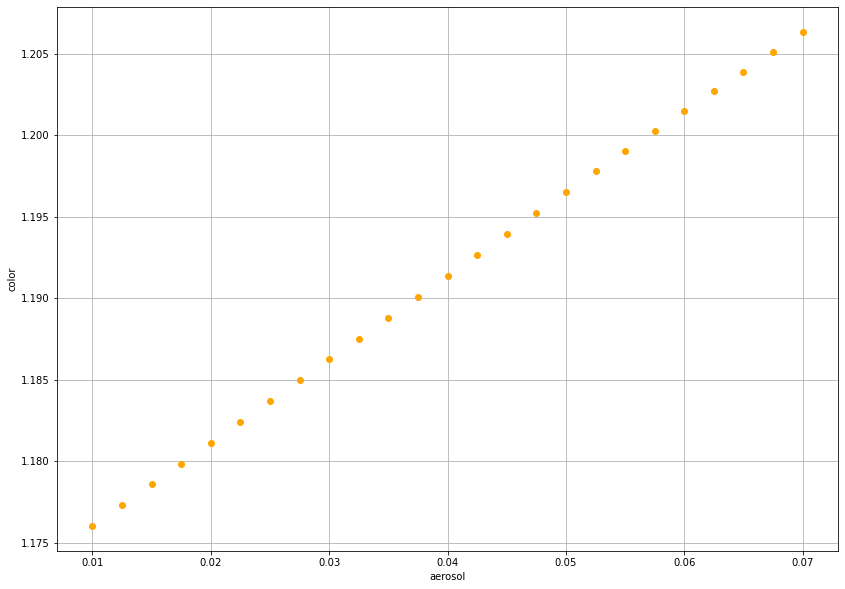

In [103]:
plt.figure(figsize=(14,10))
band1 = 'u'
band2 = 'g'
color_ = np.array(mag_dict[example_spec][band1.upper()])-np.array(mag_dict[example_spec][band2.upper()])
plt.plot(atm_vals,color_,ls='',marker='o',color='orange')
plt.grid()
plt.xlabel(variable_param)
plt.ylabel('color')

Text(0, 0.5, 'color')

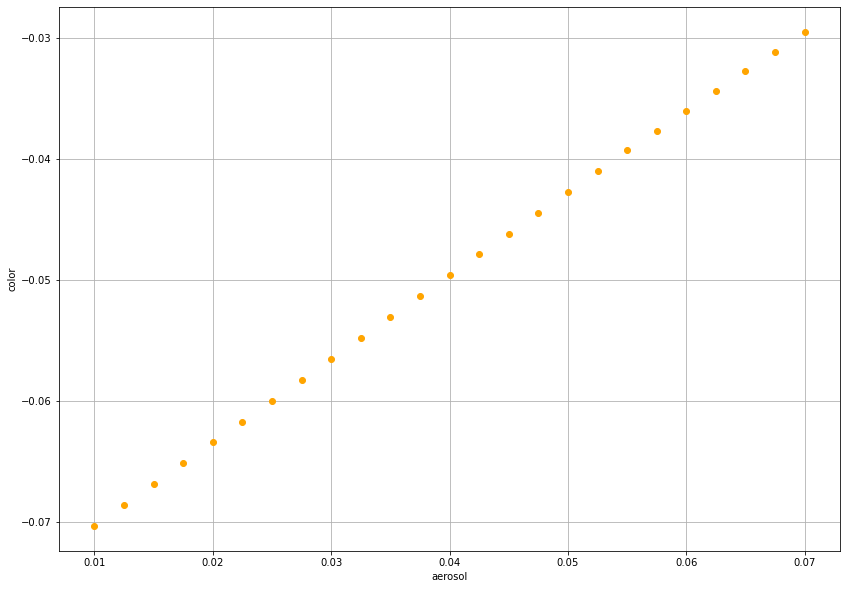

In [104]:
plt.figure(figsize=(14,10))
band1 = 'g'
band2 = 'r'
color_ = np.array(mag_dict[example_spec][band1.upper()])-np.array(mag_dict[example_spec][band2.upper()])
plt.plot(atm_vals,color_,ls='',marker='o',color='orange')
plt.grid()
plt.xlabel(variable_param)
plt.ylabel('color')

Text(0, 0.5, '$\\Delta$(g-r)')

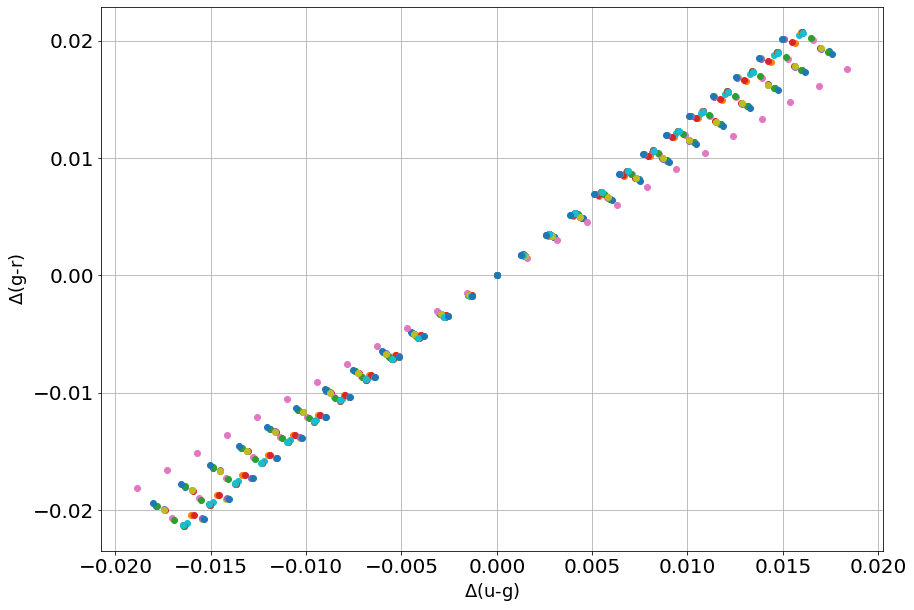

In [105]:
colorx = 'u-g'
colory = 'g-r'
plt.figure(figsize=(14,10))
for sed_ in colour_dict.keys():
    delta1 = colour_dict[sed_][colorx]-colour_dict_ref[sed_][colorx]
    delta2 = colour_dict[sed_][colory]-colour_dict_ref[sed_][colory]
    plt.plot(delta1,delta2,ls='',marker='o')
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+')',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+')',fontsize=18)
#plt.savefig('delta_colours_test.png')

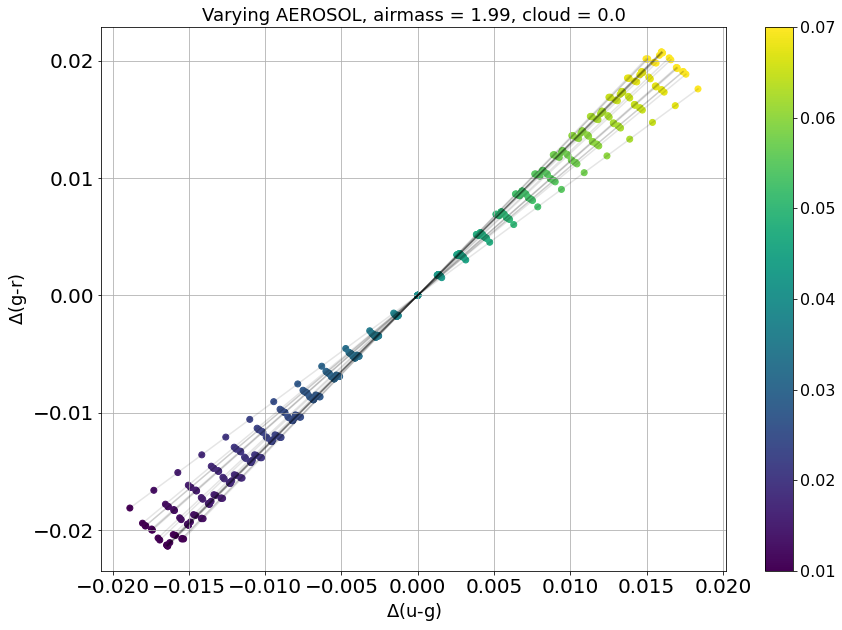

In [106]:
colorx = 'u-g'
colory = 'g-r'
plt.figure(figsize=(14,10))
for sed_ in list(colour_dict.keys()):
    delta1 = colour_dict[sed_][colorx]-colour_dict_ref[sed_][colorx]
    delta2 = colour_dict[sed_][colory]-colour_dict_ref[sed_][colory]
    plt.plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
    plt.scatter(delta1,delta2,c=atm_vals)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+')',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+')',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
if variable_param=='airmass' or variable_param=='cloud':
    plt.title('Varying {0}'.format(variable_param.upper()),fontsize=18)
else:
    plt.title('Varying {0}, airmass = {1}, cloud = {2}'.format(variable_param.upper(),am0,cloud0),fontsize=18)
if variable_param=='airmass' or variable_param=='cloud':
    plt.savefig('delta_colours_test_{0}.png'.format(variable_param))
else:
    plt.savefig('delta_colours_test_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0))

/tmp/ipykernel_23471/4178999933.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14,10))


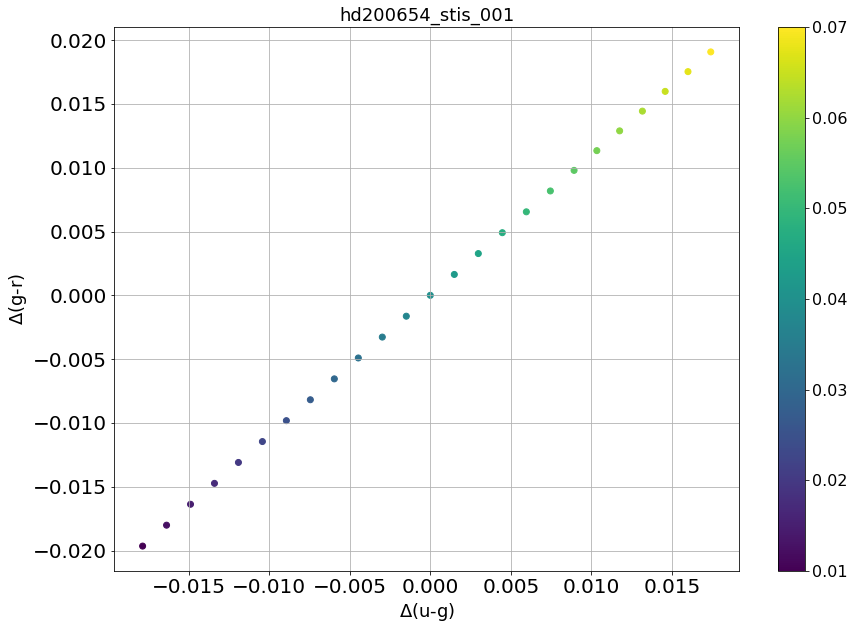

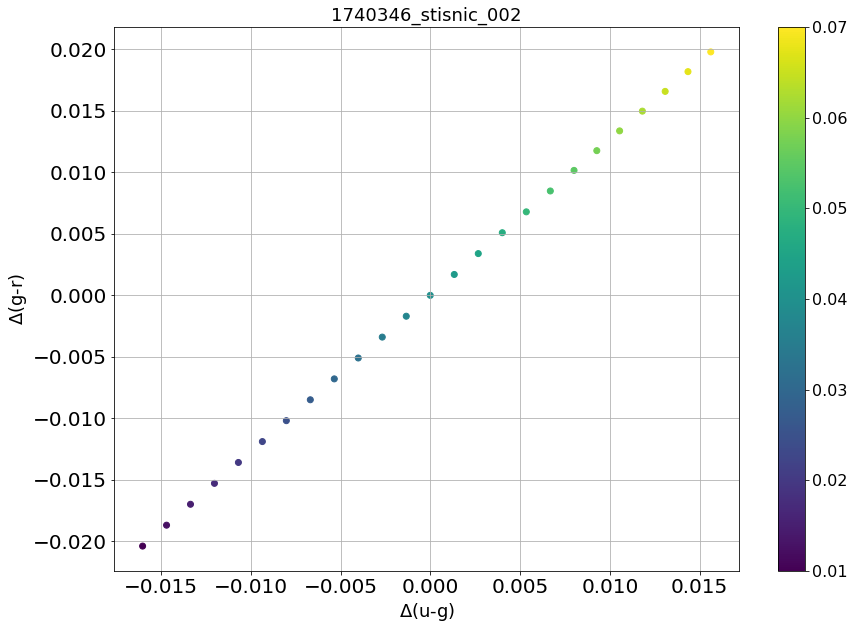

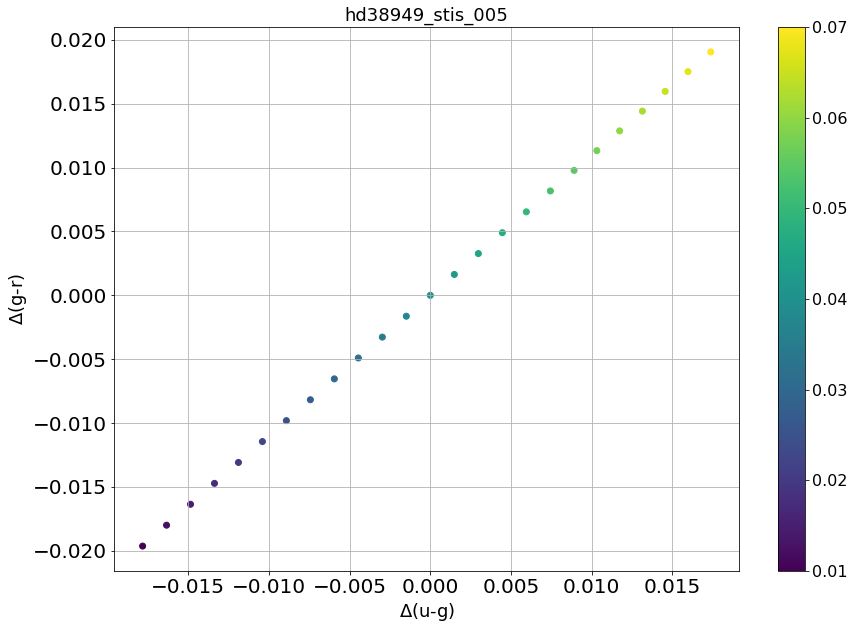

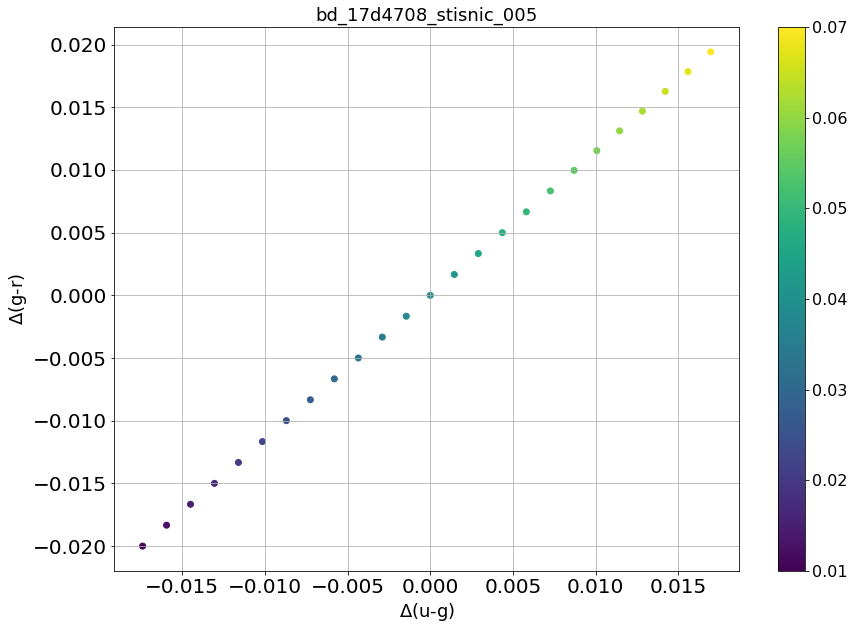

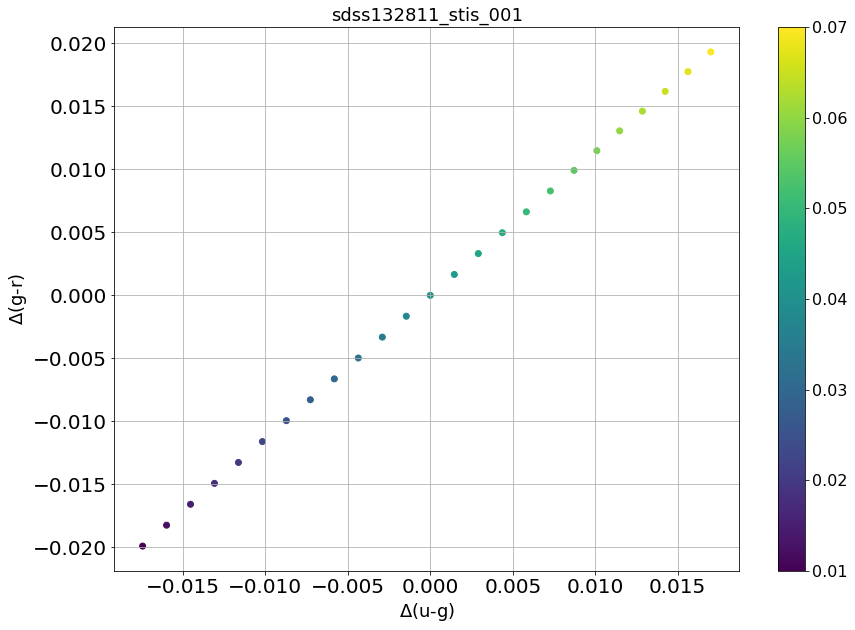

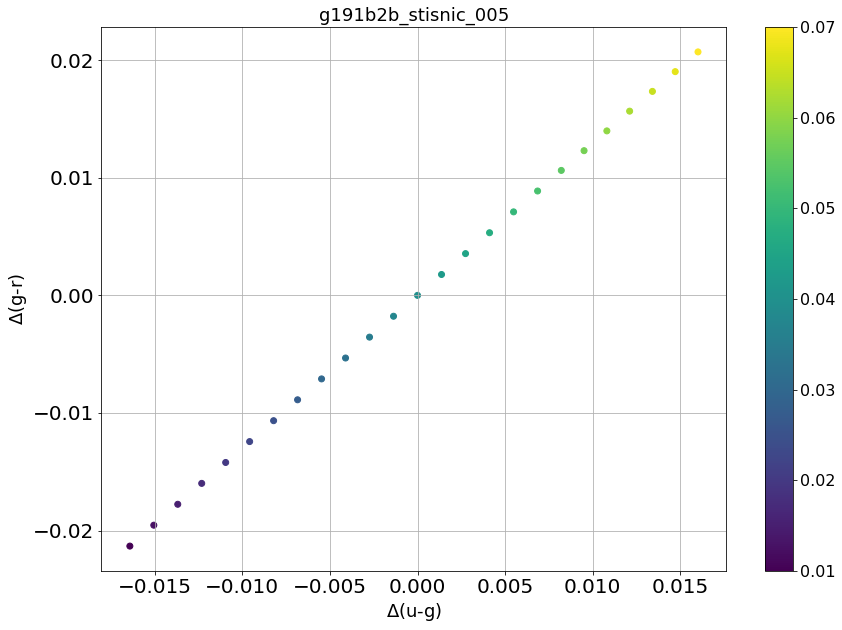

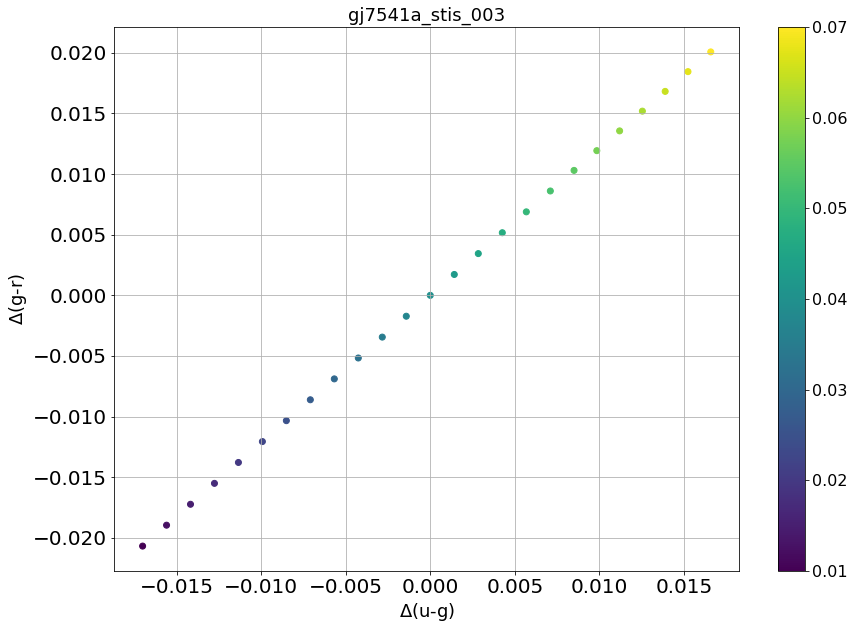

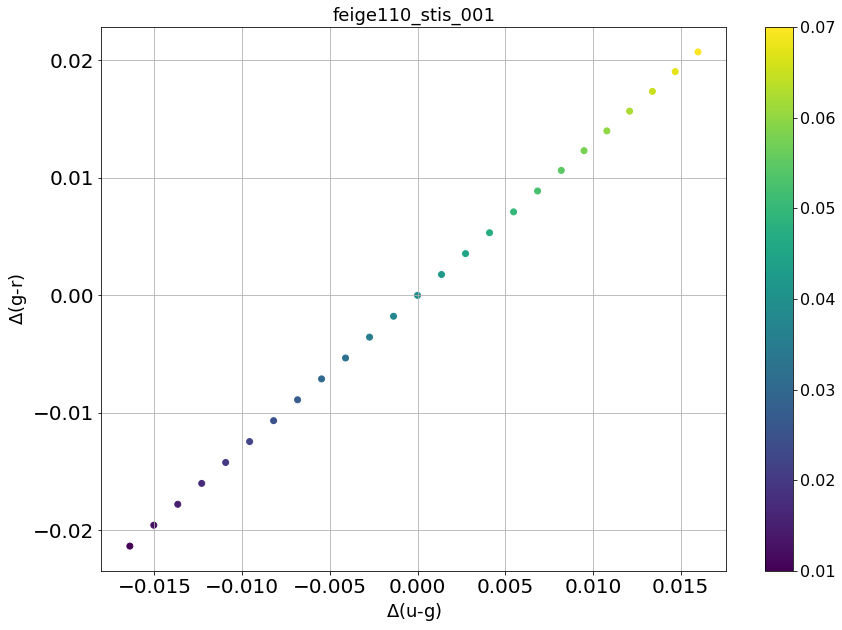

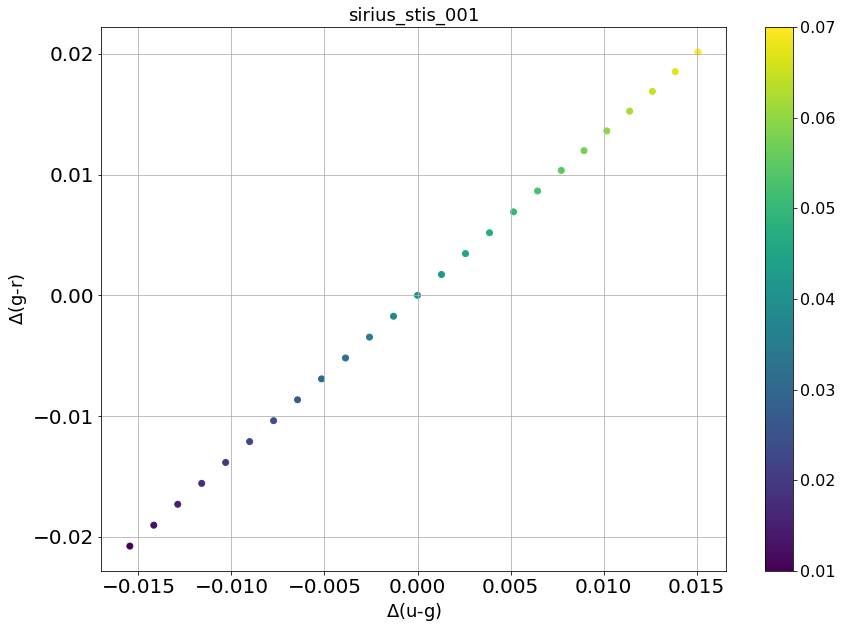

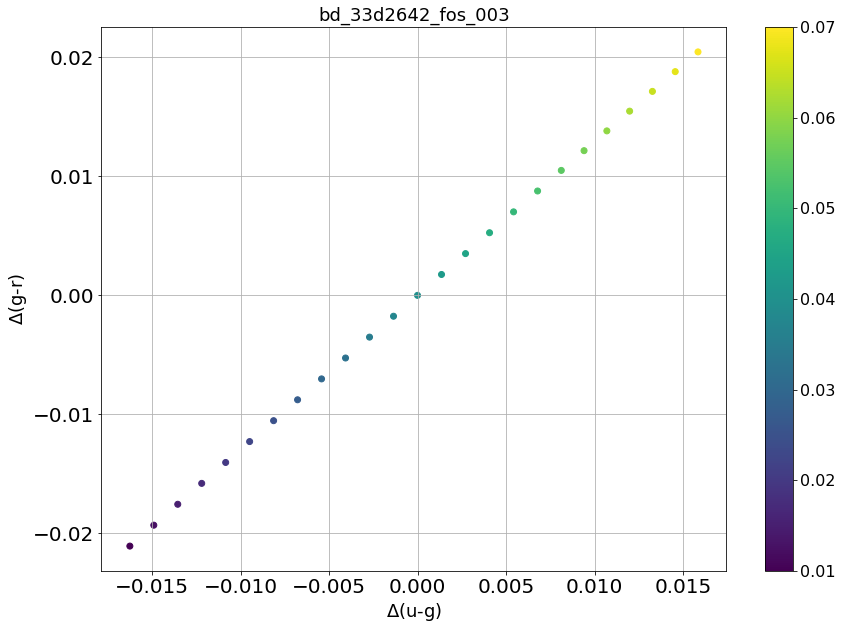

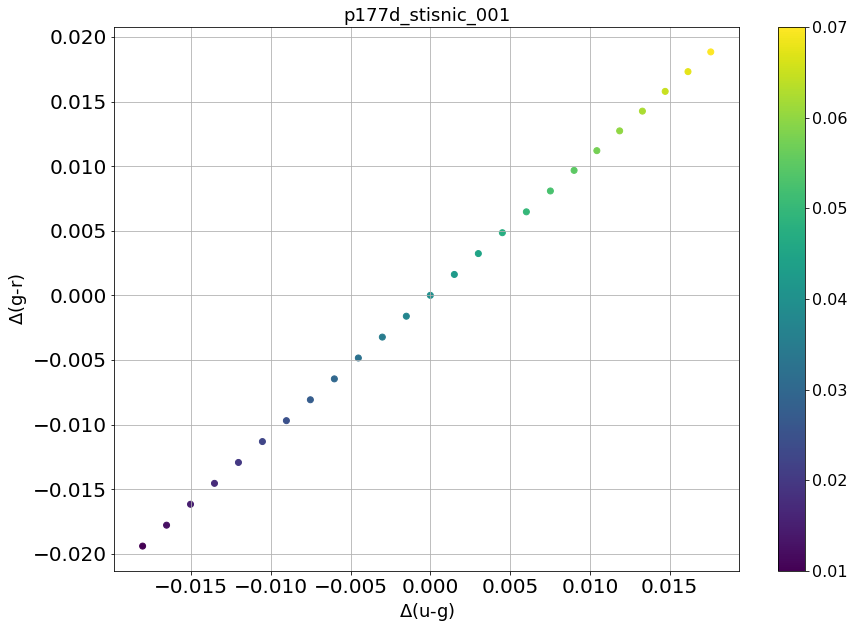

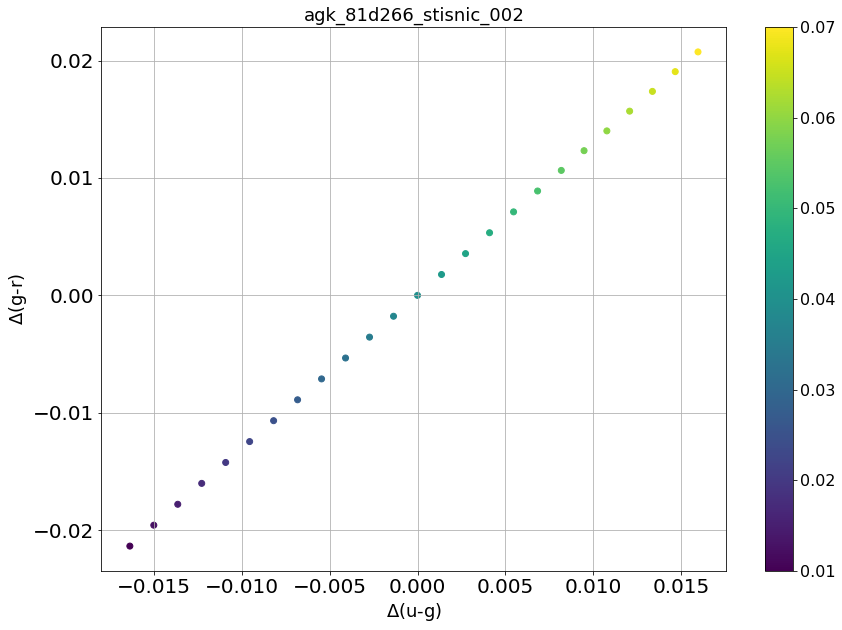

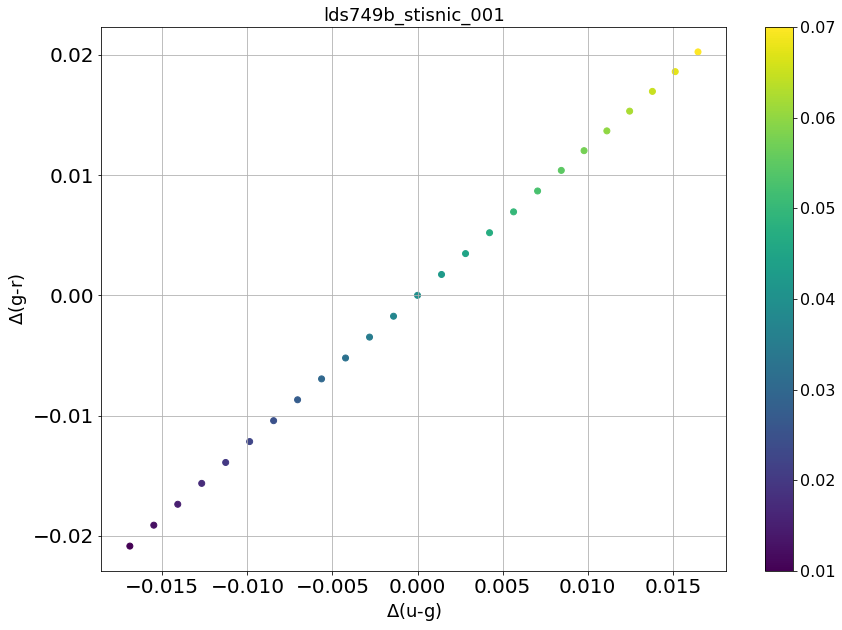

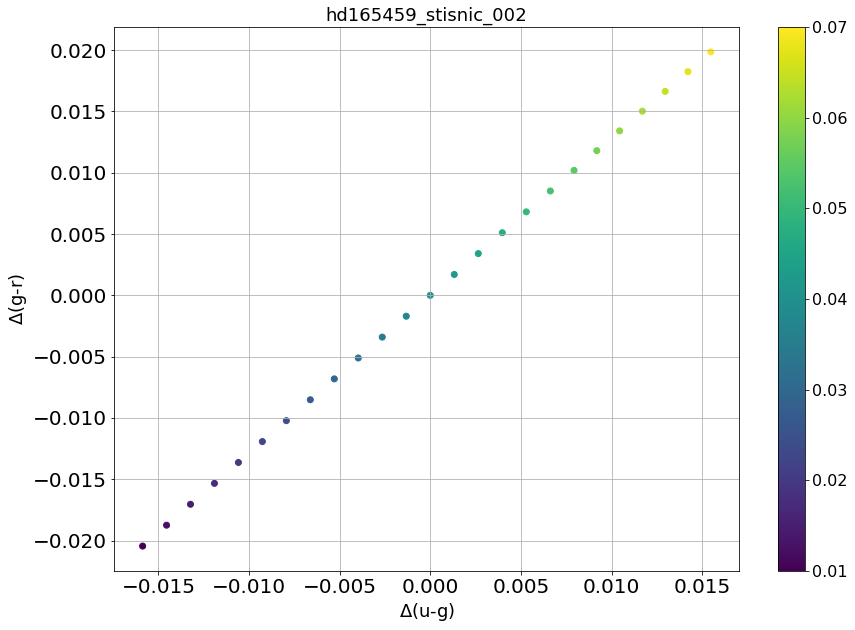

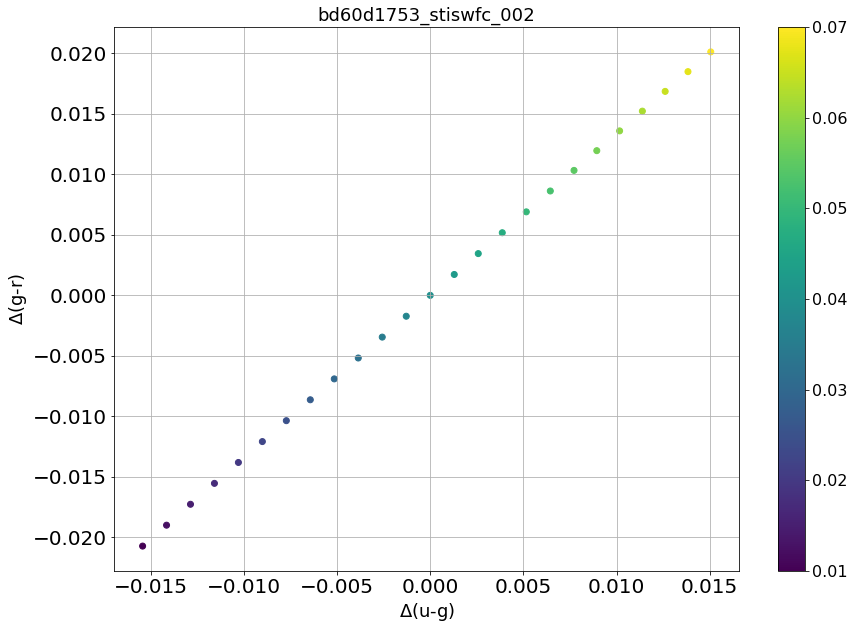

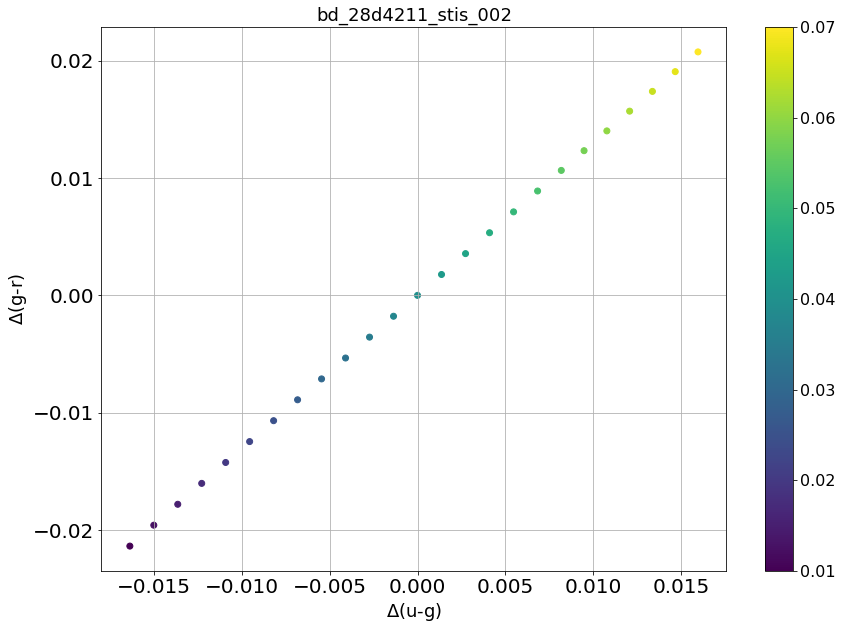

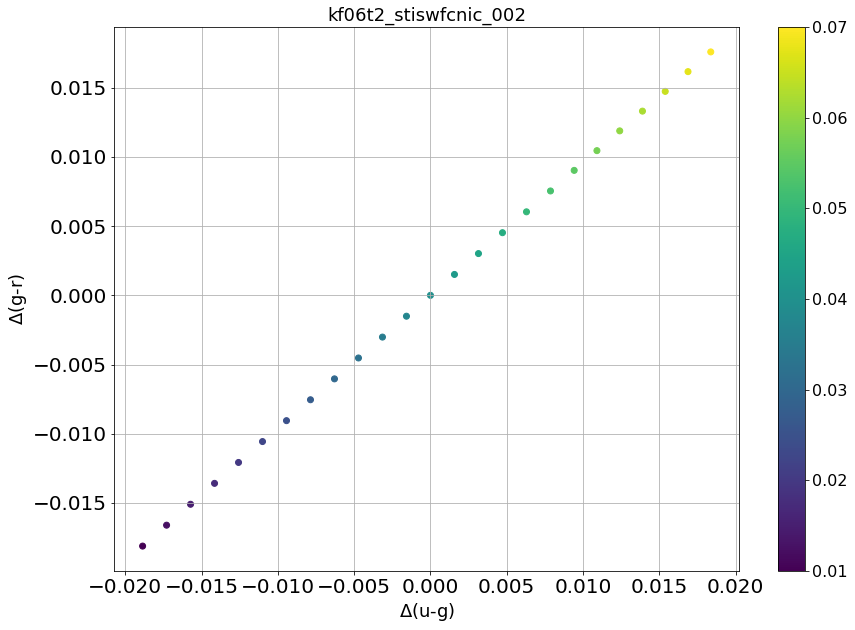

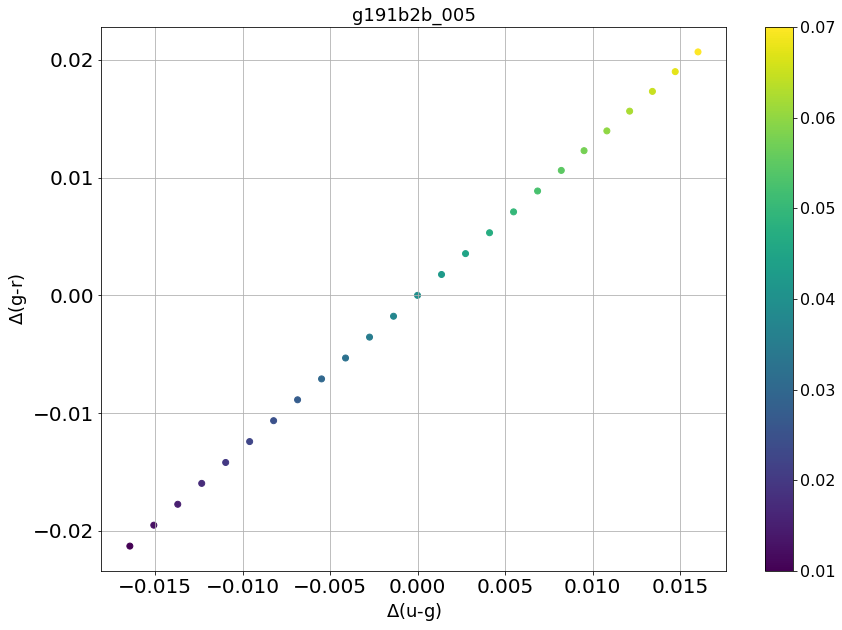

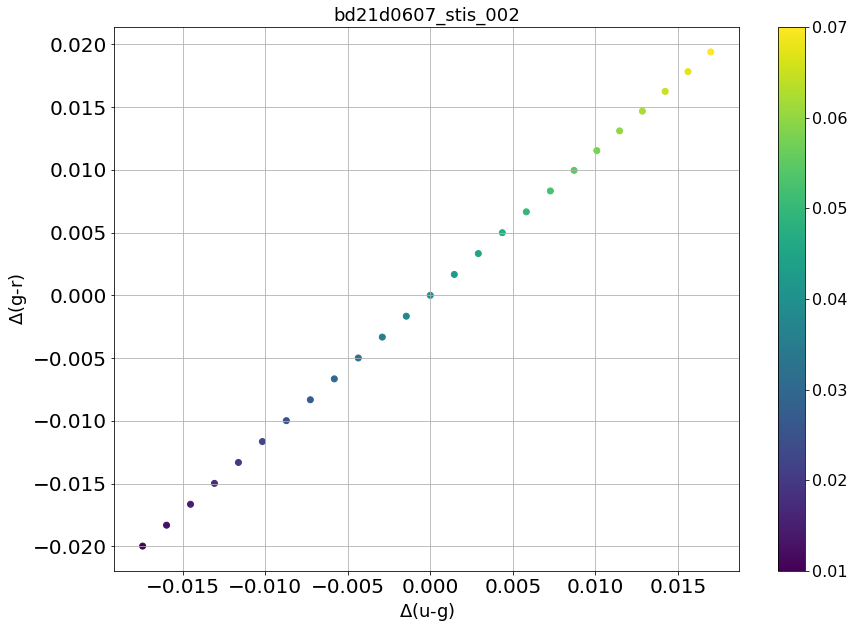

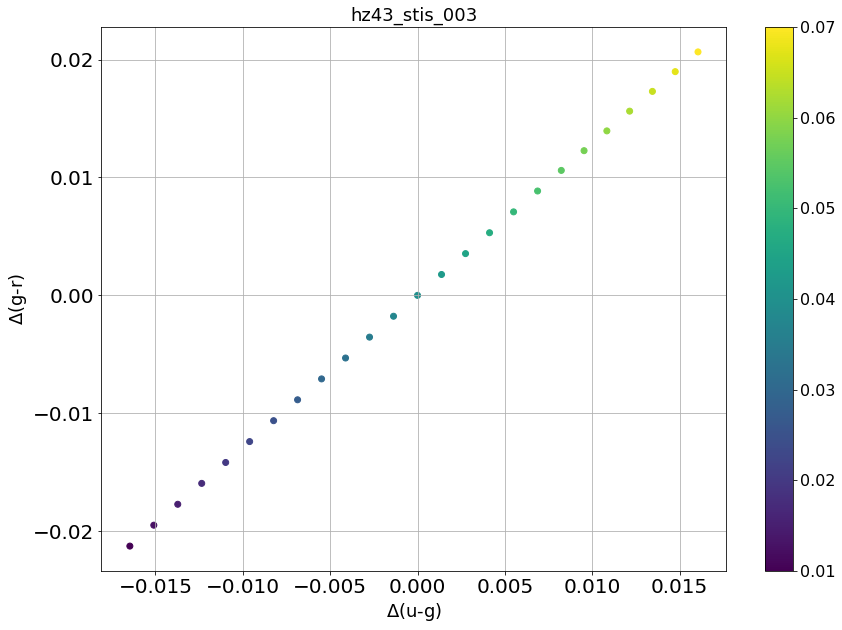

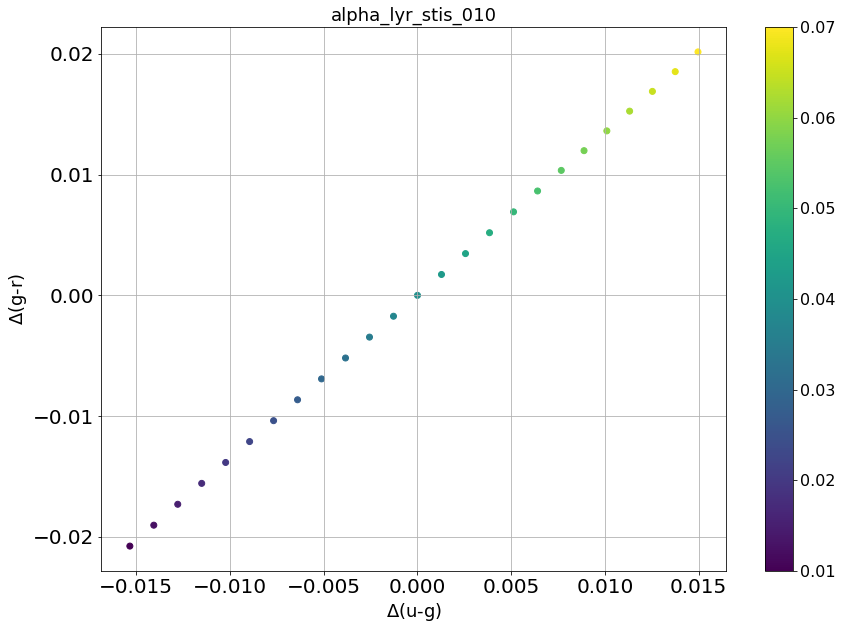

In [107]:
colorx = 'u-g'
colory = 'g-r'
for sed_ in list(colour_dict.keys()):
    plt.figure(figsize=(14,10))
    delta1 = colour_dict[sed_]['u-g']-colour_dict_ref[sed_]['u-g']
    delta2 = colour_dict[sed_]['g-r']-colour_dict_ref[sed_]['g-r']
    plt.scatter(delta1,delta2,c=atm_vals)
    plt.grid()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$\Delta$'+'('+colorx+')',fontsize=18)
    plt.ylabel(r'$\Delta$'+'('+colory+')',fontsize=18)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=16)
    plt.title(sed_,fontsize=18)


Text(0.5, 1.0, 'Varying aerosols')

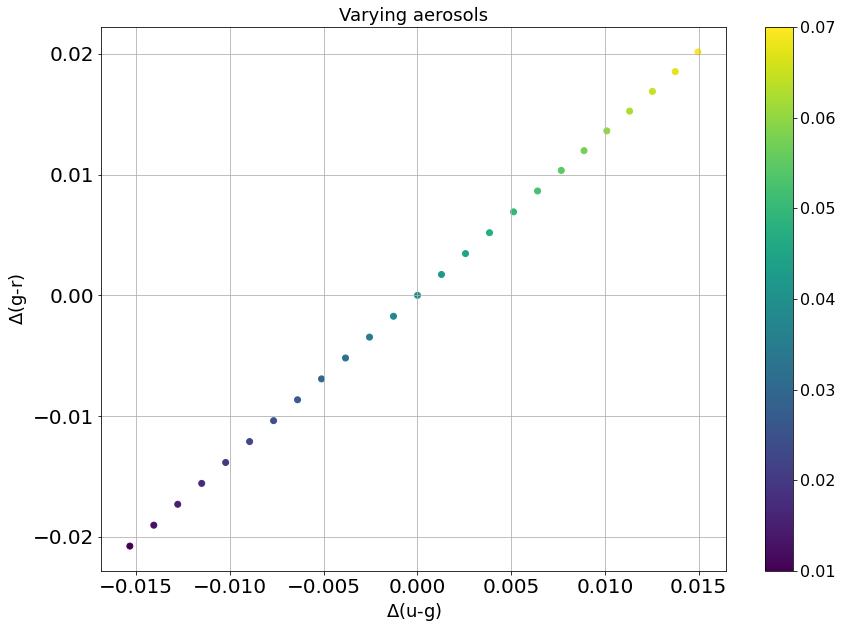

In [108]:
colorx = 'u-g'
colory = 'g-r'
plt.figure(figsize=(14,10))
delta1 = colour_dict[example_spec]['u-g']-colour_dict_ref[example_spec]['u-g']
delta2 = colour_dict[example_spec]['g-r']-colour_dict_ref[example_spec]['g-r']
plt.scatter(delta1,delta2,c=atm_vals)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+')',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+')',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('Varying aerosols',fontsize=18)
#plt.savefig('delta_colours_test.png')

In [109]:
mag_dict[example_spec]['U'][min_ind_]

1.4277075277690847

In [110]:
mag_dict[example_spec]['U'][max_ind_]

1.5985921456990573

In [111]:
np.min(mag_dict[example_spec]['U']), np.max(mag_dict[example_spec]['U'])

(1.4277075277690847, 1.5985921456990573)

In [112]:
colour_dict[example_spec]['u-g'][min_ind_]

1.1760382784451895

In [113]:
colour_dict[example_spec]['u-g'][max_ind_]

1.206346138689101

In [114]:
np.min(colour_dict[example_spec]['u-g']), np.max(colour_dict[example_spec]['u-g'])

(1.1760382784451895, 1.206346138689101)